In [1]:
import numpy as np
import joblib
from AuNR_Automated_Analysis import Absorption_decon, Deconvolution_Output
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob 
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.stats as stats
import sys
from Input_Object_Creation import Input_Object, test_spectra_fit
import numba
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter
from matplotlib.cm import ScalarMappable
%load_ext autoreload
%autoreload 2

In [2]:
size_df = pd.read_csv('Size DF Corrections 11_23.csv')
tem_results = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/TEM_Results/*.mat')

In [3]:
def extract_spectra(bulk_spectra_csv):
    names = bulk_spectra_csv['Name']
    spectra = []
    for name in names:
        print(name)
        spectrum_df = bulk_spectra_csv.loc[bulk_spectra_csv['Name']==name, :]
        cols = spectrum_df.columns
        wavelengths_a = []
        wavelengths_s = []
        wavelengths = []
        for col in cols:
            if col[0] == 'a':
                wavelengths_a.append(col)
        if len(wavelengths_a) != 0:
            for wavelength in wavelengths_a:
                if int(wavelength[1:len(wavelength)]) < 1376:
                    wavelengths.append(int(wavelength[1:len(wavelength)]))
        for col in cols:
            if col[0] in ['1', '2', '3','4','5','6','7','8','9']:
                wavelengths_s.append(col)
                wavelengths.append(int(float(col)))

        if len(wavelengths_a) != 0:
            spectrum = [name, np.asarray(wavelengths), np.asarray(spectrum_df[wavelengths_a[0:len(wavelengths)]])[0]]
        elif len(wavelengths_s) != 0: 
            spectrum = [name, np.asarray(wavelengths), np.asarray(spectrum_df[wavelengths_s[0:len(wavelengths)]])[0]]
        spectra.append(spectrum)
    return spectra

In [4]:
def run_fit_on_all_red_cutoff(spectrum, output_filepath = None, smoothing_params = (51, 3), red_edge_cuttoff = 790):
    Decon_obj = Absorption_decon(spectrum, smooth_spectrum = True, pick_longitudinal = True, 
                                 blue_baseline = False, show_sim = False, smoothing_parameters = smoothing_params, 
                                 min_longitudinal_threshold = 0.001) 
    if Decon_obj.bad_spectrum == True:
        pass
    elif Decon_obj.longitudinal_peak_wavelength < red_edge_cuttoff: 
        pass
    else: 
        if Decon_obj.blue_threshold <= 0.02:
            Decon_obj = Absorption_decon(spectrum, smooth_spectrum = True, pick_longitudinal = False, blue_baseline = False, 
                                         show_sim = False, blue_edge_location = red_edge_cuttoff, smoothing_parameters = smoothing_params) 
            output_object = Decon_obj.fit_frontend('len_dia_correlation', print_params=False, show_plot = False, 
                                                   simulation_baseline = False, show_distributions = False, 
                                                   rebaseline_spectrum = False)
            print(output_object.name)
            for name in size_df['Name']:
                if name == output_object.name: 
                    print(name)
                    true_vals = []
                    for column in size_df.columns[1:len(size_df.columns)]:
                        true_vals.append(np.asarray(size_df.loc[(size_df["Name"]==name)][column])[0])
                    output_object.true_values = true_vals
                    print(true_vals)
            for tem in tem_results:     
                if output_object.name in tem:
                    output_object.add_tems(tem, 'mat')
                    output_object.process_tems('mat')
            output_object.tabulate_results()
            # output_object.compare_distributions_to_tem()
            output_object.fit_description = str(red_edge_cuttoff) + ' nm on, red edge threhsold = None. Fully automated procedure'
            joblib.dump(output_object, output_filepath + 'len_dia_correlation' + Decon_obj.name +  str(red_edge_cuttoff) + 
                        '_nm_on.joblib')
            return output_object

In [5]:
spectra_loaded = pd.read_csv('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/NIMBUS Spectra/Nimbus_070721_post_clean_use.csv')
spectra_loaded = spectra_loaded.rename(columns={'Unnamed: 0': "Name"})
spectra = extract_spectra(spectra_loaded)

A11_Post_Clean
A12_Post_Clean
A7_Post_Clean
B2_Post_Clean
B2_Post_Clean_sonic_0720
B3_Post_Clean
B3_Post_Clean_sonic_0720
B4_Post_Clean
B4_Pre_Clean_sonic_0720
B6_post_clean_REAL
B8_Post_Clean
C2_Post_Clean
C3_Post_Clean
C4_Post_Clean
C7_Post_Clean
D12_Post_Clean_sonic_071621
D1_Post_Clean
D4_Post_Clean
D5_Post_Clean
E12_Post_Clean
F12_Post_Clean_sonic_071621
F2_Post_Clean
F2_Post_Clean_sonic_071321
F3_Post_Clean
F3_Post_Clean_sonic_071321
F4_Post_Clean
F4_Post_Clean_sonic_071321
G12_Post_Clean_sonic_071621
G4_Post_Clean
G4_Post_Clean_sonic_071321
G5_Post_Clean
G6_Post_Clean
H1_Post_Clean_actually_g7
H1_Post_Clean_REAL
H2_Post_Clean
H2_Post_Clean_sonic_071621
H3_Post_Clean
H3_Post_Clean_REAL
H3_Post_Clean_sonic_071621
H4_Post_Clean
H4_Post_Clean_sonic_071621
H7_Post_Clean_sonic_071621
D1_nimbus_051221
C2_nimbus_051221
D2_nimbus_051221
H2_nimbus_052621
C4_nimbus_052621
E4_nimbus_052621
G3_nimbus_052621
C2_nimbus_062521_rnd_1
H12
H12_0707


In [6]:
tems_csv = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/TEM_Results/*.csv')
tems_mat = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/TEM_Results/*.mat')

In [5]:
cutoffs = np.arange(700, 860, 10)
cutoffs

array([700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820,
       830, 840, 850])

C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff\len_dia_correlationA11_Post_Clean790_nm_on.joblib
len_dia_correlation
1.0000000000000004
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │  0.247396 │ 52.5(4.4) 10.2(1.8) 5.3(1.0)                │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
A11_Post_Clean
len_dia_correlation
1.0000000000000004
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │  0.247396 │ 52.5(4.4) 10.2(1.8) 5.3(1.0)                │
╘═════════════════════╧════════

╒═════════════════════╤════════════╤════════════════════════════════════════════╕
│ Model Type          │    Overlap │ Predictions 39.9(15.3) 9.4(6.8) 4.4(1.0)   │
╞═════════════════════╪════════════╪════════════════════════════════════════════╡
│ len_dia_correlation │ 1.7514e-06 │ 145.4(20.0) 42.8(2.7) 3.4(0.3)             │
╘═════════════════════╧════════════╧════════════════════════════════════════════╛
C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff\len_dia_correlationF12_Post_Clean_sonic_071621790_nm_on.joblib
len_dia_correlation
0.9999999999999999
╒═════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 36.9(9.1) 8.6(2.0) 4.3(0.9)   │
╞═════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len_dia_correlation │ 0.0234203 │ 89.1(18.2) 21.6(6.2) 4.3(0.9)             │
╘═════════════════════╧═══════════╧═══════════════════════════════════════════╛


C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff\len_dia_correlationKatherinne_Requejo_2017_FigureS6A_Red_same_spectrum_as_Katherinne_Requejo_2017_Figure_1A_Orange_3790_nm_on.joblib
Katherinne_Requejo_2017_FigureS6A_Red_same_spectrum_as_Katherinne_Requejo_2017_Figure_1A_Orange_3
╒═════════════════════╤═══════════╤═════════════════════════════════════════════════╕
│ Model Type          │ Overlap   │ Predictions 45.41(4.59) 6.72(0.35) 6.77(0.73)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════════╡
│ len_dia_correlation │ NA        │ 83.4(8.4) 13.0(4.2) 6.6(1.4)                    │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════════╛
C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff\len_dia_correlationKatherinne_Requejo_2017_Figure_1A_Orange_3790_nm_on.joblib
Katherinne_Requejo_2017_Figure_1A_Orange_3
╒═════════════════════╤═══════════╤═══════

C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff\len_dia_correlationXingchen_Figure4_pink790_nm_on.joblib
Xingchen_Figure4_pink
╒═════════════════════╤═══════════╤═══════════════════════════════════════════════╕
│ Model Type          │ Overlap   │ Predictions 93.9(11.2) 11.0(1.1) 8.537(nan)   │
╞═════════════════════╪═══════════╪═══════════════════════════════════════════════╡
│ len_dia_correlation │ NA        │ Failed Fit, all fits hit bounds               │
╘═════════════════════╧═══════════╧═══════════════════════════════════════════════╛
C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff\len_dia_correlationXingchen_Figure4_red790_nm_on.joblib
Xingchen_Figure4_red
╒═════════════════════╤═══════════╤══════════════════════════════════════════════════╕
│ Model Type          │ Overlap   │ Predictions 103.0(8.0) 16.3(0.8) 6.319018(nan)   │
╞═════════════════════╪═══════════╪═══════════════════════════════════════

C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff\len_dia_correlationZhang_2021_Figure_S5_Red790_nm_on.joblib
Zhang_2021_Figure_S5_Red
╒═════════════════════╤═══════════╤══════════════════════════════════════════════╕
│ Model Type          │ Overlap   │ Predictions 60.1(6.4) 15.8(1.2) 3.83(0.57)   │
╞═════════════════════╪═══════════╪══════════════════════════════════════════════╡
│ len_dia_correlation │ NA        │ Failed Fit, all fits hit bounds              │
╘═════════════════════╧═══════════╧══════════════════════════════════════════════╛
C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff\len_dia_correlationZhang_2021_Figure_S6b_DarkYellow790_nm_on.joblib
Zhang_2021_Figure_S6b_DarkYellow
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │ Overlap   │ Predictions 73.9(5.5) 20.6(0.7) 3.6(0.33)   │
╞═════════════════════╪═══════════╪════════════════════════

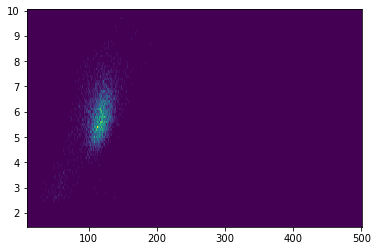

In [7]:
final_output_files = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff/*.joblib')

for file in final_output_files[0:len(final_output_files)]:
    print(file)
    output_file = joblib.load(file)
    if type(output_file) != list:
        for name in size_df['Name']:
                if name == output_file.name: 
                    # print("name found in size df")
                    # print(name)
                    true_vals = []
                    for column in size_df.columns[1:len(size_df.columns)]:
                        true_vals.append(np.asarray(size_df.loc[(size_df["Name"]==name)][column])[0])
                    output_file.true_values = true_vals
                    # print(true_vals)
                    # print("end size df adding")
        # print(output_file.fit_results['fit_spheres_temp'][0][0][3])
        """
        for name in size_df['Name']:
            if name in file: 
                true_vals = []
                for column in size_df.columns[1:len(size_df.columns)]:
                    true_vals.append(np.asarray(size_df.loc[(size_df["Name"]==name)][column])[0])
                output_file.true_values = true_vals
        """
        for tem_csv in tems_csv:
            name = output_file.name
            if '_spectrum' in name:
                underscore = name.index('_spectrum')
                name = name[0:underscore]
            if name in tem_csv:
                output_file.add_tems(tem_csv, 'csv')
                output_file.process_tems('csv')
        for tem_mat in tems_mat:
            name = output_file.name
            if '_spectrum' in name:
                underscore = name.index('_spectrum')
                name = name[0:underscore]
            if name in tem_mat:
                # print(name)
                output_file.add_tems(tem_mat, 'mat')
                output_file.process_tems('mat')
        # output_file.tabulate_results(overlap_method = 'TEMs')
        if 'Clean' in file or 'Rod' in file or 'nimbus' in file:
            try:
                temp = output_file.tabulate_results()[0][2]
                true_values = []
                temp_val = ''
                for char in temp[11:len(temp)]:
                    if char not in '()':
                        temp_val += char
                    if char in '()':
                        true_values.append(float(temp_val))
                        temp_val = ''
                output_file.true_values = true_values
            except:
                pass
        print(output_file.name)
        if output_file.true_values != []:
            if np.isnan(output_file.true_values[1]) == False and np.isnan(output_file.true_values[3]) == False:  
                try: 
                    output_file.tabulate_results()
                except AttributeError: 
                    output_file.tabulate_results(overlap_method = 'new')
            else: 
                output_file.true_values = []
                joblib.dump(output_file,'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff processed/790 nm on red cutoff not used/No true vals/' + str(output_file.name) + '.joblib')



        if name in ['Katherinne_Requejo_2018_Figure_3A_Green', 'Mbalaha_2019_Figure_3_Red', 'Wei_2021_Figure_3_Pink']:
            joblib.dump(output_file, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff processed/790 nm on red cutoff not used/Crazy synthesis conditions/' + str(output_file.name) + '.joblib')
        elif output_file.true_values == []:
            # pass
            joblib.dump(output_file, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff processed/790 nm on red cutoff not used/No true vals/' + str(output_file.name) + '.joblib')
        else: 
            joblib.dump(output_file, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff processed/790 nm on red cutoff with true vals/' + str(output_file.name) + '.joblib')
        # 10_17 = 44
    else: 
        name = output_file[1].name
        joblib.dump(output_file, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff processed/790 nm on red cutoff not used/Fit Uncertian/' + str(name) + '.joblib')

A11_Post_Clean
len_dia_correlation
1.0000000000000004


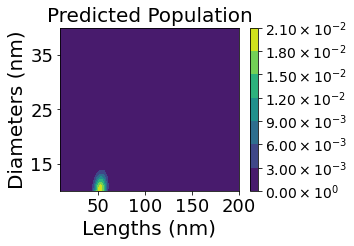

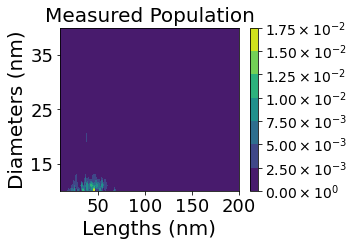

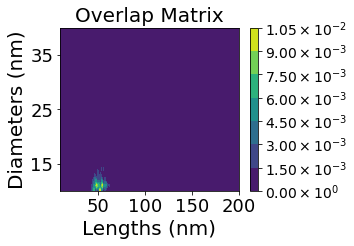

╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │  0.247396 │ 52.5(4.4) 10.2(1.8) 5.3(1.0)                │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation
1.0


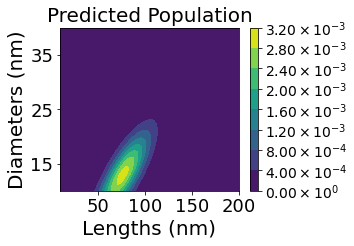

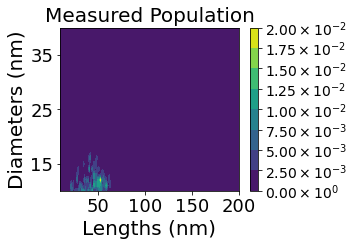

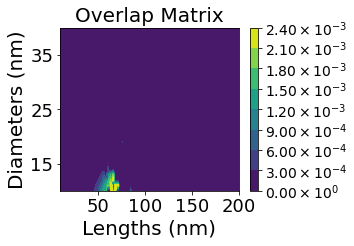

╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │  0.107632 │ 78.1(17.2) 13.6(4.6) 6.0(1.3)               │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[44.6, 13.8, 12.0, 3.9, 3.8, 1.3]
A12_Post_Clean
[44.6, 13.8, 12.0, 3.9, 3.8, 1.3]
passed filtering
A7_Post_Clean
len_dia_correlation
1.0


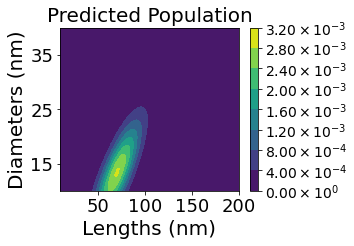

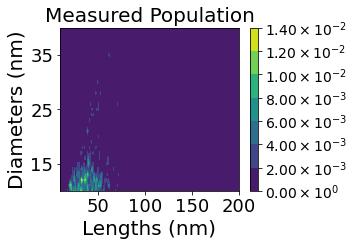

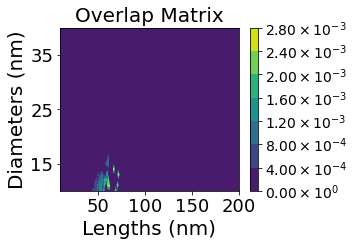

╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 36.8(12.0) 11.9(3.8) 3.2(1.1)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │ 0.0695294 │ 72.3(15.1) 14.4(5.4) 5.4(1.5)               │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[36.8, 12.0, 11.9, 3.8, 3.2, 1.1]
A7_Post_Clean
[36.8, 12.0, 11.9, 3.8, 3.2, 1.1]
passed filtering
B8_Post_Clean
len_dia_correlation
1.0000000000000002


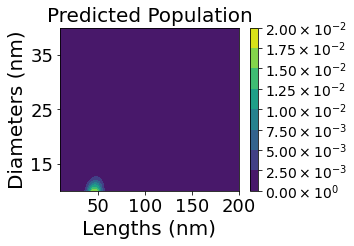

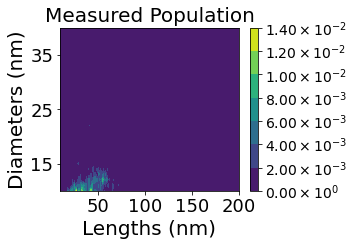

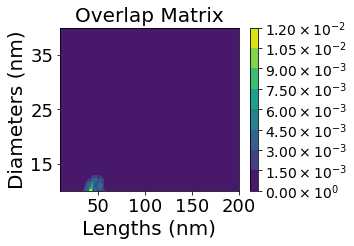

╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 37.1(13.6) 10.6(3.5) 3.5(1.1)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │  0.321969 │ 46.1(5.4) 9.3(1.6) 5.1(1.0)                 │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.1, 13.6, 10.6, 3.5, 3.5, 1.1]
B8_Post_Clean
[37.1, 13.6, 10.6, 3.5, 3.5, 1.1]
passed filtering
C7_Post_Clean
len_dia_correlation
1.0


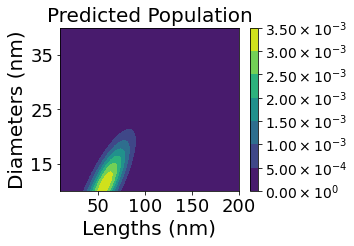

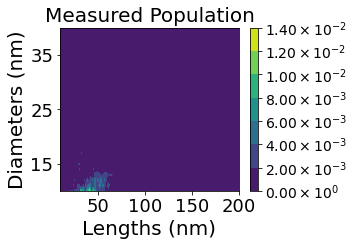

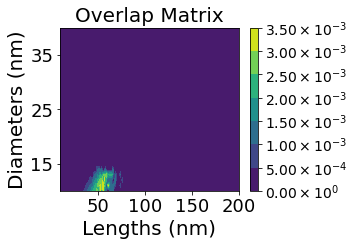

╒═════════════════════╤═══════════╤════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 35.7(13.9) 9.4(2.8) 3.8(1.2)   │
╞═════════════════════╪═══════════╪════════════════════════════════════════════╡
│ len_dia_correlation │  0.300797 │ 60.1(15.1) 12.4(4.4) 5.3(1.4)              │
╘═════════════════════╧═══════════╧════════════════════════════════════════════╛
[35.7, 13.9, 9.4, 2.8, 3.8, 1.2]
C7_Post_Clean
[35.7, 13.9, 9.4, 2.8, 3.8, 1.2]
passed filtering
Chang_2018_Figure_3_Blue
Chang_2018_Figure_3_Green
Chang_2018_Figure_3_Red
Chang_2018_Figure_3_Yellow
D12_Post_Clean_sonic_071621
len_dia_correlation
0.9999999999999999


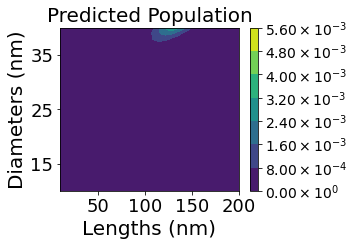

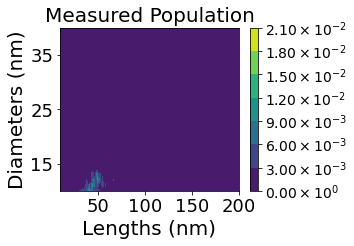

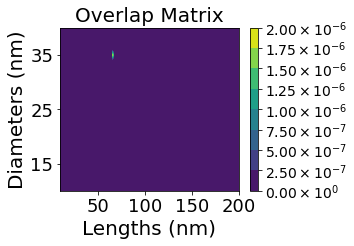

╒═════════════════════╤════════════╤════════════════════════════════════════════╕
│ Model Type          │    Overlap │ Predictions 39.9(15.3) 9.4(6.8) 4.4(1.0)   │
╞═════════════════════╪════════════╪════════════════════════════════════════════╡
│ len_dia_correlation │ 1.7514e-06 │ 145.4(20.0) 42.8(2.7) 3.4(0.3)             │
╘═════════════════════╧════════════╧════════════════════════════════════════════╛
[39.9, 15.3, 9.4, 6.8, 4.4, 1.0]
D12_Post_Clean_sonic_071621
[39.9, 15.3, 9.4, 6.8, 4.4, 1.0]
passed filtering
F12_Post_Clean_sonic_071621
len_dia_correlation
0.9999999999999999


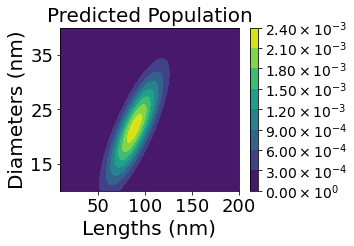

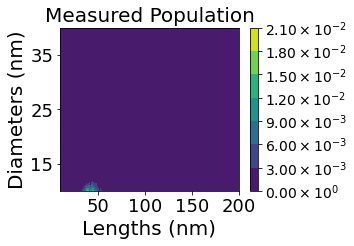

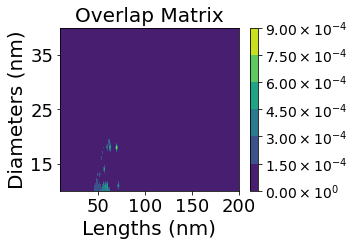

╒═════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 36.9(9.1) 8.6(2.0) 4.3(0.9)   │
╞═════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len_dia_correlation │ 0.0234203 │ 89.1(18.2) 21.6(6.2) 4.3(0.9)             │
╘═════════════════════╧═══════════╧═══════════════════════════════════════════╛
[36.9, 9.1, 8.6, 2.0, 4.3, 0.9]
F12_Post_Clean_sonic_071621
[36.9, 9.1, 8.6, 2.0, 4.3, 0.9]
passed filtering
Gallagher_2020_Figure_S11a_Blue
Gallagher_2020_Figure_S11a_Green
Gallagher_2020_Figure_S11a_Pink
Gallagher_2020_Figure_S11a_Red
Gallagher_2020_Figure_S11b_Blue
Gallagher_2020_Figure_S11b_Lavender
Gallagher_2020_Figure_S2a_Blue
Gallagher_2020_Figure_S2a_LightBlue
Gallagher_2020_Figure_S2a_Pink
Gallagher_2020_Figure_S2b_Green
Gallagher_2020_Figure_S4a_Blue
Gallagher_2020_Figure_S4a_Blue
[76.3, 6.4, 19.4, 2.0, 3.98, 0.56]
passed filtering
Gallagher_2020_Figure_S4a_LightBlue
Gallagher_2020_

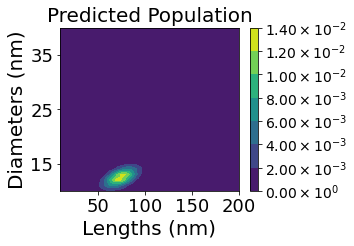

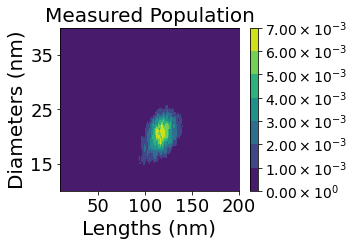

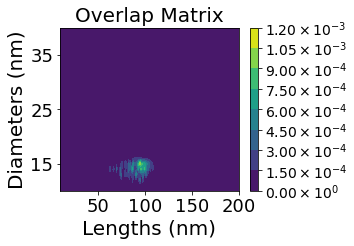

╒═════════════════════╤═══════════╤══════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 115.8(15.0) 20.2(2.8) 5.8(0.9)   │
╞═════════════════════╪═══════════╪══════════════════════════════════════════════╡
│ len_dia_correlation │ 0.0400472 │ 74.3(11.7) 12.5(1.2) 6.0(0.8)                │
╘═════════════════════╧═══════════╧══════════════════════════════════════════════╛
[115.8, 15.0, 20.2, 2.8, 5.8, 0.9]
Long Rod
[115.8, 15.0, 20.2, 2.8, 5.8, 0.9]
passed filtering
Mbalaha_2019_Figure_3_Black
Mbalaha_2019_Figure_3_Green
Wei_2021_Figure_3_Green
Wei_2021_Figure_3_Green
[105.9, 9.0, 26.2, 2.1, 4.1, 0.5]
passed filtering
Wei_2021_Figure_4f_Green
Wei_2021_Figure_4f_Green
[60.4, 11.3, 12.9, 2.5, 4.8, 1.0]
passed filtering
Xingchen_Figure4_black
Xingchen_Figure4_black
[71.5, 4.5, 12.0, 1.0, 5.958333, nan]
passed filtering
Xingchen_Figure4_blue
Xingchen_Figure4_blue
[109.8, 8.0, 15.6, 1.0, 7.0384, nan]
passed filtering
Xingchen_Figure4_green
Xingchen_Fi

['790_nm_on_red_cutoff.joblib']

In [26]:
output_files = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/790 nm on red cutoff processed/790 nm on red cutoff with true vals/*.joblib')

output_files_for_analysis = []
for file in output_files:
    output_file = joblib.load(file)
    if type(output_file) != list: 
        print(output_file.name)
        if 'Clean' in file or 'Rod' in file or 'nimbus' in file:
            temp = output_file.tabulate_results()[0][2]
            true_values = []
            temp_val = ''
            for char in temp[11:len(temp)]:
                if char not in '()':
                    temp_val += char
                if char in '()':
                    true_values.append(float(temp_val))
                    temp_val = ''
            output_file.true_values = true_values
            print(output_file.true_values)
        if output_file.smoothed_spectrum[len(output_file.smoothed_spectrum)-1] < 0.5:
            if 'Zhang_2021' not in file: 
                smoothed_spectrum = savgol_filter(output_file.inputted_spectrum, output_file.smoothing_parameters[0], output_file.smoothing_parameters[1])
                inten_max = max(smoothed_spectrum)
                peak_loc = list(smoothed_spectrum).index(inten_max)
                wavelength_loc = output_file.wavelengths[peak_loc]
                if wavelength_loc > 790+5:
                    try: 
                        if float(output_file.true_values[2]) > 6: 
                            print(output_file.name)
                            print(output_file.true_values)
                            print('passed filtering')
                            output_files_for_analysis.append(output_file)
                    except TypeError:
                        pass
test_spectra_obj = test_spectra_fit('790 nm on red cutoff', 'Blue edge cutoff value in fit summary, location' + 
                                    'still 650 for spectra where red edge doesnt go to the baseline', output_files_for_analysis)
joblib.dump(test_spectra_obj, '790_nm_on_red_cutoff.joblib')
# summary_stats.append(test_spectra_obj.visualize_overlaps(str(cutoff)))

In [4]:
for cutoff in cutoffs: 
    final_output_files = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/' + str(cutoff) +' nm on/*.joblib')

    for file in final_output_files[0:len(final_output_files)]:
        print(file)
        output_file = joblib.load(file)
        if type(output_file) != list:
            for name in size_df['Name']:
                    if name == output_file.name: 
                        # print("name found in size df")
                        # print(name)
                        true_vals = []
                        for column in size_df.columns[1:len(size_df.columns)]:
                            true_vals.append(np.asarray(size_df.loc[(size_df["Name"]==name)][column])[0])
                        output_file.true_values = true_vals
                        # print(true_vals)
                        # print("end size df adding")
            # print(output_file.fit_results['fit_spheres_temp'][0][0][3])
            """
            for name in size_df['Name']:
                if name in file: 
                    true_vals = []
                    for column in size_df.columns[1:len(size_df.columns)]:
                        true_vals.append(np.asarray(size_df.loc[(size_df["Name"]==name)][column])[0])
                    output_file.true_values = true_vals
            """
            for tem_csv in tems_csv:
                name = output_file.name
                if '_spectrum' in name:
                    underscore = name.index('_spectrum')
                    name = name[0:underscore]
                if name in tem_csv:
                    output_file.add_tems(tem_csv, 'csv')
                    output_file.process_tems('csv')
            for tem_mat in tems_mat:
                name = output_file.name
                if '_spectrum' in name:
                    underscore = name.index('_spectrum')
                    name = name[0:underscore]
                if name in tem_mat:
                    # print(name)
                    output_file.add_tems(tem_mat, 'mat')
                    output_file.process_tems('mat')
            # output_file.tabulate_results(overlap_method = 'TEMs')
            if 'Clean' in file or 'Rod' in file or 'nimbus' in file:
                try:
                    temp = output_file.tabulate_results()[0][2]
                    true_values = []
                    temp_val = ''
                    for char in temp[11:len(temp)]:
                        if char not in '()':
                            temp_val += char
                        if char in '()':
                            true_values.append(float(temp_val))
                            temp_val = ''
                    output_file.true_values = true_values
                except:
                    pass
            print(output_file.name)
            if output_file.true_values != []:
                if np.isnan(output_file.true_values[1]) == False and np.isnan(output_file.true_values[3]) == False:  
                    try: 
                        output_file.tabulate_results()
                    except AttributeError: 
                        output_file.tabulate_results(overlap_method = 'new')
                else: 
                    output_file.true_values = []
                    joblib.dump(output_file, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/' + str(cutoff) +' nm on processed/' + str(cutoff) +' nm on not used/No true vals/' + str(output_file.name) + '.joblib')



            if name in ['Katherinne_Requejo_2018_Figure_3A_Green', 'Mbalaha_2019_Figure_3_Red', 'Wei_2021_Figure_3_Pink']:
                joblib.dump(output_file, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/' + str(cutoff) +' nm on processed/' + str(cutoff) +' nm on not used/Crazy synthesis conditions/' + str(output_file.name) + '.joblib')
            elif output_file.true_values == []:
                # pass
                joblib.dump(output_file, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/' + str(cutoff) +' nm on processed/' + str(cutoff) +' nm on not used/No true vals/' + str(output_file.name) + '.joblib')
            else: 
                joblib.dump(output_file, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/' + str(cutoff) +' nm on processed/' + str(cutoff) +' nm on with true vals/' + str(output_file.name) + '.joblib')
            # 10_17 = 44
        else: 
            name = output_file[1].name
            joblib.dump(output_file, 'C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/' + str(cutoff) +' nm on processed/' + str(cutoff) +' nm on not used/Fit Uncertian/' + str(name) + '.joblib')

NameError: name 'cutoffs' is not defined

In [9]:
test_spectra_obj = joblib.load('790' + '_nm_on.joblib')

In [21]:
for i in range(0, 47):
    print(test_spectra_obj.output_objects[i].name, i)

A11_Post_Clean 0
A12_Post_Clean 1
A7_Post_Clean 2
B2_Post_Clean 3
B3_Post_Clean 4
B4_Pre_Clean_sonic_0720 5
B8_Post_Clean 6
C2_nimbus_051221 7
C2_nimbus_062521_rnd_1 8
C4_nimbus_052621 9
C4_Post_Clean 10
C7_Post_Clean 11
D12_Post_Clean_sonic_071621 12
D1_nimbus_051221 13
D2_nimbus_051221 14
D4_Post_Clean 15
Dopamine Bottom Fig panel 3 corrected 16
F12_Post_Clean_sonic_071621 17
G3_nimbus_052621 18
G4_Post_Clean 19
Gallagher_2020_Figure_S7a_Pink 20
H1_Post_Clean 21
H4_Post_Clean 22
Katherinne_Requejo_2017_FigureS6A_Green 23
Katherinne_Requejo_2017_FigureS6A_Red_same_spectrum_as_Katherinne_Requejo_2017_Figure_1A_Orange_3 24
Katherinne_Requejo_2017_Figure_1A_Orange_3 25
Katherinne_Requejo_2018_Figure_3A_Blue 26
Katherinne_Requejo_2018_Figure_3A_Yellow 27
Katherinne_Requejo_2018_Figure_3B_Purple 28
Katherinne_Requejo_2018_Figure_6_Blue 29
Katherinne_Requejo_2018_Figure_6_Red 30
Liu_2017_Figure_5_Orange 31
Long Rod 32
Mbalaha_2019_Figure_3_LightBlue 33
Murphy_2011_Abstract_Blue 34
Tong_2017

In [6]:
# test_spectra_obj.visualize_overlaps('temp')

In [10]:
dir(test_spectra_obj.output_objects[0])

['TEM_results',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_tems',
 'add_true_vals',
 'ar_len_matrix_ars',
 'ars',
 'ars_to_hist',
 'bivariate_gaussian_len_dia',
 'blue_baseline_intens',
 'blue_baseline_wavelengths',
 'blue_edge_location',
 'calc_overlap_from_lit',
 'calculate_overlap',
 'compare_distributions_to_tem',
 'compare_to_true_vals',
 'diameters',
 'diameters_to_hist',
 'display_predicted_values',
 'extracted_longitudinal',
 'fit_description',
 'fit_h12',
 'fit_results',
 'generate_true_predicted_distributions',
 'get_true_vals',
 'inputted_spectrum',
 'lengths',
 'lengths_to_hist',
 'longitudinal_threshold',
 'longitudinal_wavelengths',
 'name',
 'o

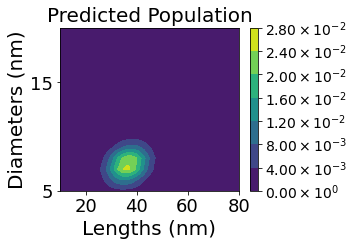

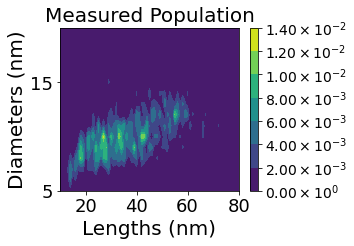

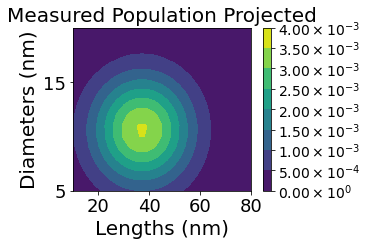

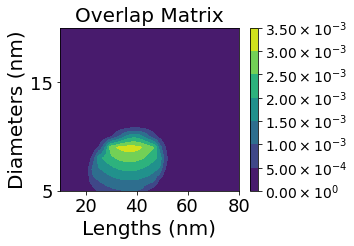

╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.1(13.6) 10.6(3.5) 3.5(1.1)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.266226 │ 36.5(5.5) 7.6(1.1) 5.0(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
B8_Post_Clean


In [18]:
index = 6

test_spectra_obj.output_objects[index].tabulate_results(overlap_method = 'new', show_plot = True)
print(test_spectra_obj.output_objects[index].name)

C:\Users\smgls\PycharmProjects\UC_Berkeley_Research_second_year\AuNR_HT_synthesis_and_analysis\Size_Deconvolution_files\Fully_Automated\AuNR_Automated_Analysis.py:6621: UserWarning: The following kwargs were not used by contour: 'cm'
  plt.contourf(self.lengths, self.diameters, population_matrix, cm='viridis')


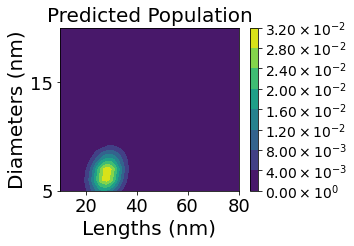

C:\Users\smgls\PycharmProjects\UC_Berkeley_Research_second_year\AuNR_HT_synthesis_and_analysis\Size_Deconvolution_files\Fully_Automated\AuNR_Automated_Analysis.py:6637: UserWarning: The following kwargs were not used by contour: 'cm'
  plt.contourf(self.lengths, self.diameters, self.true_pop_matrix.T, cm='viridis')


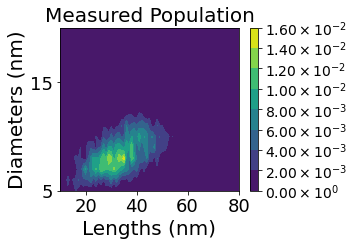

C:\Users\smgls\PycharmProjects\UC_Berkeley_Research_second_year\AuNR_HT_synthesis_and_analysis\Size_Deconvolution_files\Fully_Automated\AuNR_Automated_Analysis.py:6653: UserWarning: The following kwargs were not used by contour: 'cm'
  plt.contourf(self.lengths, self.diameters, true_matrix_from_means, cm='viridis')


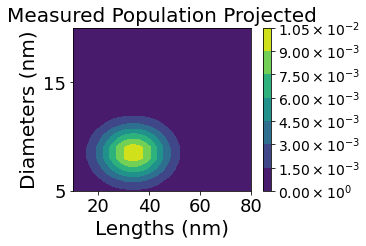

C:\Users\smgls\PycharmProjects\UC_Berkeley_Research_second_year\AuNR_HT_synthesis_and_analysis\Size_Deconvolution_files\Fully_Automated\AuNR_Automated_Analysis.py:6669: UserWarning: The following kwargs were not used by contour: 'cm'
  plt.contourf(self.lengths, self.diameters, overlap_matrix.T, cm='viridis')


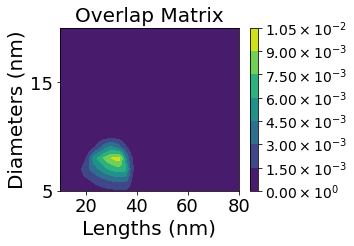

╒═════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 33.7(9.4) 8.5(1.7) 4.0(1.0)   │
╞═════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len_dia_correlation │  0.348909 │ 28.3(4.2) 7.2(1.3) 4.4(0.9)               │
╘═════════════════════╧═══════════╧═══════════════════════════════════════════╛
C2_nimbus_051221


In [17]:
index = 7

test_spectra_obj.output_objects[index].tabulate_results(overlap_method = 'new', show_plot = True)
print(test_spectra_obj.output_objects[index].name)

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252987 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102305 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

D2_nimbus_051221
len_dia_correlation
╒═════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type          │ Overlap   │ Predictions 30.4(8.9) 8.0(1.8) 3.8(1.0)   │
╞═════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len_dia_correlation │ NA        │ Failed Fit, all fits hit bounds           │
╘═════════════════════╧═══════════╧═══════════════════════════════════════════╛
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
D2_nimbus_051221
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
passed filtering
D4_Post_Clean
len_dia_correlation
1.0000000000000002
╒═════════════════════╤════════════╤═════════════════════════════════════════════╕
│ Model Type          │    Overlap │ Predictions 52.4(24.6) 17.0(9.7) 3.2(0.7)   │
╞═════════════════════╪════════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │ 0.00760808 │ 94.5(9.2) 21.8(4.9) 4.5(0.9)                │
╘═════════════════════╧════════════╧════════════════════════════════════════════

Long Rod
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤══════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 115.8(15.0) 20.2(2.8) 5.8(0.9)   │
╞═════════════════════════════╪═══════════╪══════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.564931 │ 107.0(24.3) 19.1(4.3) 5.7(0.9)               │
╘═════════════════════════════╧═══════════╧══════════════════════════════════════════════╛
[115.8, 15.0, 20.2, 2.8, 5.8, 0.9]
Long Rod
[115.8, 15.0, 20.2, 2.8, 5.8, 0.9]
passed filtering
Mbalaha_2019_Figure_2_Black
Mbalaha_2019_Figure_2_Red
Mbalaha_2019_Figure_3_Black
Mbalaha_2019_Figure_3_Blue
Mbalaha_2019_Figure_3_Green
Mbalaha_2019_Figure_3_LightBlue
Mbalaha_2019_Figure_3_LightBlue
[23.9, 3.9, 6.6, 1.1, 3.6, nan]
passed filtering
Mbalaha_2019_Figure_3_Pink
Mbalaha_2019_Figure_3_Yellow
Rafael_del_Cano_2019_Figure 1 Red
Rafael_del_Cano_2019_Figure 1 Red
[63.0, 12.0, 18.0, 6.0, 2.4, 1.1]


[60.48182074405113, 10.879596142779796, 12.836890509094744, 2.1230734946836596, 4.730405748903761, 0.5447818405052842]
Xingchen_Figure3_red
[51.119344136137215, 7.667813964257011, 12.002326362588438, 1.868376432804646, 4.2851139472406565, 0.4336413591927873]
Xingchen_Figure4_black
[73.78890510417384, 12.592516516807676, 13.192644880257461, 3.4222719524364744, 5.80180173974563, 1.0410752501848304]
Xingchen_Ye_2013_Figure_2H_Dark_Cyan
[32.76497979080529, 2.47118186314316, 10.112603611125795, 0.8319866323955605, 3.258311992965022, 0.32962426261754163]
Xingchen_Ye_2013_Figure_5_Black
[21.422866632602194, 2.836104692637502, 6.763821145102632, 0.7075969885514924, 3.2493594815511675, 0.49889085947267026]
Xingchen_Ye_2013_Figure_5_Magenta
[32.11644353742301, 1.9762392945207417, 10.234010573136045, 1.1137427549426946, 3.1726137454447136, 0.3722456022732471]
Xingchen_Ye_2013_Figure_5_Red
[36.24067140689124, 1.9508735305672458, 10.83720834021951, 1.1532057255641721, 3.378808750530885, 0.380666090

mean overlap = 0.18239468635561018
std overlap = 0.20870069948705036
median overlap = 0.06617624793583873


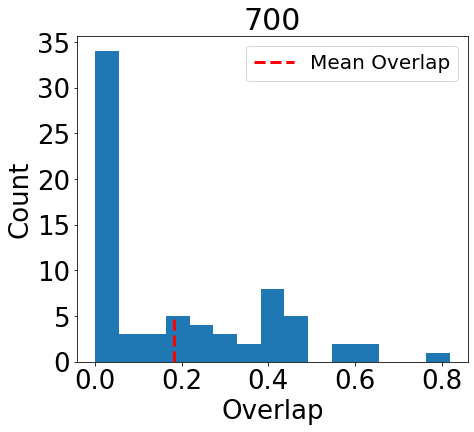

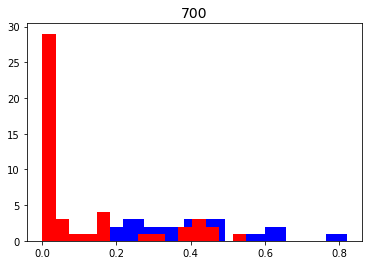

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252987 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102305 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

1.0000000000000002
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 52.4(24.6) 17.0(9.7) 3.2(0.7)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │ 0.0115265 │ 91.9(9.5) 21.0(4.8) 4.5(0.9)                │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[52.4, 24.6, 17.0, 9.7, 3.2, 0.7]
D4_Post_Clean
[52.4, 24.6, 17.0, 9.7, 3.2, 0.7]
passed filtering
Dopamine Bottom Fig panel 3 corrected
Dopamine Bottom Fig panel 3 corrected
[97.1, 16.0, 20.2, 4.62, 4.9, 0.9]
passed filtering
F12_Post_Clean_sonic_071621
len_dia_correlation_rel_std
0.9999999999999999
╒═════════════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 36.9(9.1) 8.6(2.0) 4.3(0.9)   │
╞═════════════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len

Mbalaha_2019_Figure_3_Yellow
Rafael_del_Cano_2019_Figure 1 Red
Rafael_del_Cano_2019_Figure 1 Red
[63.0, 12.0, 18.0, 6.0, 2.4, 1.1]
passed filtering
Tong_2017_Figure_1b_Blue
Tong_2017_Figure_1b_Magenta
Tong_2017_Figure_1b_Wine
Tong_2017_Figure_S1_Blue
Tong_2017_Figure_S1_Blue
[32.0, 10.0, 11.0, 2.0, 3.0, 0.7]
passed filtering
Tong_2017_Figure_S1_Green
Tong_2017_Figure_S1_Green
[32.0, 10.0, 12.0, 2.0, 2.7, 0.7]
passed filtering
Tong_2017_Figure_S1_LightBlue
Tong_2017_Figure_S1_LightBlue
[38.0, 10.0, 11.0, 2.0, 3.5, 0.7]
passed filtering
Tong_2017_Figure_S1_Pink
Tong_2017_Figure_S1_Pink
[40.0, 9.0, 10.0, 2.0, 3.8, 0.7]
passed filtering
Wei_2021_Figure_3_Blue
Wei_2021_Figure_3_Blue
[112.6, 9.4, 36.8, 3.1, 3.1, 0.4]
passed filtering
Wei_2021_Figure_3_Green
Wei_2021_Figure_3_Green
[105.9, 9.0, 26.2, 2.1, 4.1, 0.5]
passed filtering
Wei_2021_Figure_4f_Black
Wei_2021_Figure_4f_Black
[130.1, 13.0, 60.8, 4.0, 2.2, 0.3]
passed filtering
Wei_2021_Figure_4f_Blue
Wei_2021_Figure_4f_Blue
[102.9, 9.7, 

C4_nimbus_052621
[89.2092264114441, 21.14038174438278, 23.71741945071048, 6.425263637086234, 3.869792305132928, 0.7625910244800665]
C4_Post_Clean
[91.21206228208241, 11.681852734254337, 20.724879996141343, 3.409608119311234, 4.509454103806615, 0.8960271579257152]
C7_Post_Clean
[36.88493259323451, 6.258514880352784, 7.786666689643306, 1.2822527990115697, 4.946939122743844, 1.0872384993060942]
Chang_2018_Figure_2_Red
[53.177905651078376, 8.37170883369168, 15.512872360129794, 1.850594588473423, 3.4658917461956262, 0.6279723975206422]
D12_Post_Clean_sonic_071621
[34.076506781685254, 4.651152579974423, 7.346641680527633, 0.991668732688004, 4.785924919542374, 0.8466077859920282]
D1_nimbus_051221
[28.935642908370824, 4.229457524933739, 7.282336443842308, 1.4074265296060111, 4.4939996361757, 0.9373060098140303]
D4_Post_Clean
[91.8887972710649, 9.546264231877519, 21.016108118854557, 4.797573900491517, 4.540699500988186, 0.866504850835589]
Dopamine Bottom Fig panel 3 corrected
[111.0883078504857

mean overlap = 0.20048126219014814
std overlap = 0.21063643911936533
median overlap = 0.14062714066601226


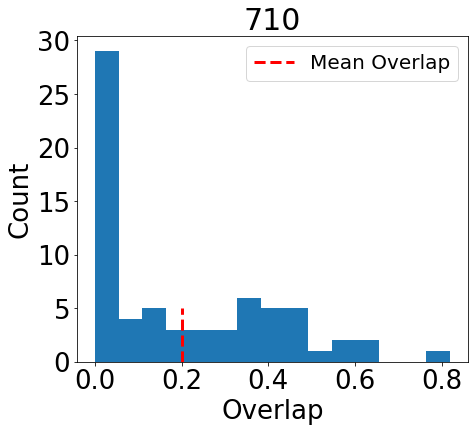

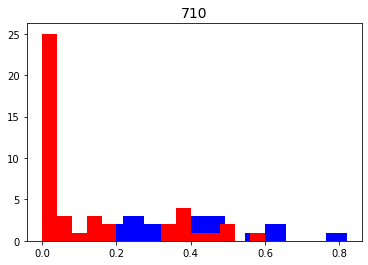

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252987 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102305 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

D2_nimbus_051221
len_dia_correlation
0.9999999999999997
╒═════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 30.4(8.9) 8.0(1.8) 3.8(1.0)   │
╞═════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len_dia_correlation │  0.263947 │ 46.9(9.2) 11.4(2.0) 4.2(0.9)              │
╘═════════════════════╧═══════════╧═══════════════════════════════════════════╛
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
D2_nimbus_051221
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
passed filtering
D4_Post_Clean
len_dia_correlation
1.0000000000000002
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 52.4(24.6) 17.0(9.7) 3.2(0.7)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │ 0.0177109 │ 88.6(9.9) 20.1(4.7) 4.6(0.9)                │
╘═════════════════════╧═══════════╧══════════════════════════════

Mbalaha_2019_Figure_3_Green
Mbalaha_2019_Figure_3_LightBlue
Mbalaha_2019_Figure_3_LightBlue
[23.9, 3.9, 6.6, 1.1, 3.6, nan]
passed filtering
Mbalaha_2019_Figure_3_Pink
Mbalaha_2019_Figure_3_Yellow
Rafael_del_Cano_2019_Figure 1 Red
Rafael_del_Cano_2019_Figure 1 Red
[63.0, 12.0, 18.0, 6.0, 2.4, 1.1]
passed filtering
Tong_2017_Figure_1b_Magenta
Tong_2017_Figure_1b_Wine
Tong_2017_Figure_S1_Blue
Tong_2017_Figure_S1_Blue
[32.0, 10.0, 11.0, 2.0, 3.0, 0.7]
passed filtering
Tong_2017_Figure_S1_Green
Tong_2017_Figure_S1_Green
[32.0, 10.0, 12.0, 2.0, 2.7, 0.7]
passed filtering
Tong_2017_Figure_S1_LightBlue
Tong_2017_Figure_S1_LightBlue
[38.0, 10.0, 11.0, 2.0, 3.5, 0.7]
passed filtering
Tong_2017_Figure_S1_Pink
Tong_2017_Figure_S1_Pink
[40.0, 9.0, 10.0, 2.0, 3.8, 0.7]
passed filtering
Wei_2021_Figure_3_Blue
Wei_2021_Figure_3_Blue
[112.6, 9.4, 36.8, 3.1, 3.1, 0.4]
passed filtering
Wei_2021_Figure_3_Green
Wei_2021_Figure_3_Green
[105.9, 9.0, 26.2, 2.1, 4.1, 0.5]
passed filtering
Wei_2021_Figure_4f_B

[40.487669012808674, 6.995701865303448, 12.331724358682855, 0.9391864752509135, 3.2676146353346622, 0.4015007675713998]
H1_Post_Clean
[31.213205808268494, 3.4129859630481496, 7.315706904453139, 1.517714844659495, 4.944458657800373, 0.9466252220750567]
H2_nimbus_052621
[71.56938495275026, 14.31713684124552, 20.260131607756847, 5.313342921164658, 3.6551877012706235, 0.7069117631264206]
H4_Post_Clean
[88.59494043868354, 15.313698887267485, 23.02144892720127, 5.189123455054766, 3.9390999398586413, 0.6182807002452443]
Katherinne_Requejo_2017_FigureS6A_Green
[35.596001446861635, 4.557147775692167, 7.078456896090683, 0.9004449183502709, 5.208561371113197, 0.8606616800492114]
Katherinne_Requejo_2017_FigureS6A_Red_same_spectrum_as_Katherinne_Requejo_2017_Figure_1A_Orange_3
[44.298551816345736, 6.82143562380471, 7.451414811992398, 1.1222619703753154, 6.185968213538112, 1.196794792483105]
Katherinne_Requejo_2017_Figure_1A_Orange_3
[45.217611294516075, 7.208676605097312, 7.489731775185646, 1.16283

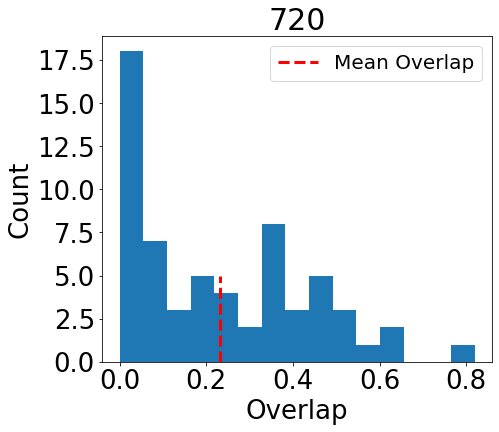

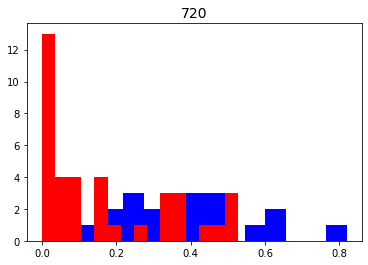

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252987 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102305 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

╒═════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 30.4(8.9) 8.0(1.8) 3.8(1.0)   │
╞═════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len_dia_correlation │  0.182797 │ 48.0(7.8) 11.5(1.7) 4.2(0.8)              │
╘═════════════════════╧═══════════╧═══════════════════════════════════════════╛
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
D2_nimbus_051221
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
passed filtering
D4_Post_Clean
len_dia_correlation
1.0000000000000002
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 52.4(24.6) 17.0(9.7) 3.2(0.7)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │ 0.0332174 │ 83.4(10.4) 18.6(4.5) 4.7(0.9)               │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[52.4, 24.6, 17.0, 9.7, 3.2, 0.7]
D4_Po

Mbalaha_2019_Figure_3_Pink
Mbalaha_2019_Figure_3_Yellow
Rafael_del_Cano_2019_Figure 1 Red
Rafael_del_Cano_2019_Figure 1 Red
[63.0, 12.0, 18.0, 6.0, 2.4, 1.1]
passed filtering
Tong_2017_Figure_1b_Magenta
Tong_2017_Figure_1b_Wine
Tong_2017_Figure_S1_Blue
Tong_2017_Figure_S1_Blue
[32.0, 10.0, 11.0, 2.0, 3.0, 0.7]
passed filtering
Tong_2017_Figure_S1_Green
Tong_2017_Figure_S1_Green
[32.0, 10.0, 12.0, 2.0, 2.7, 0.7]
passed filtering
Tong_2017_Figure_S1_LightBlue
Tong_2017_Figure_S1_LightBlue
[38.0, 10.0, 11.0, 2.0, 3.5, 0.7]
passed filtering
Tong_2017_Figure_S1_Pink
Tong_2017_Figure_S1_Pink
[40.0, 9.0, 10.0, 2.0, 3.8, 0.7]
passed filtering
Wei_2021_Figure_3_Blue
Wei_2021_Figure_3_Blue
[112.6, 9.4, 36.8, 3.1, 3.1, 0.4]
passed filtering
Wei_2021_Figure_3_Green
Wei_2021_Figure_3_Green
[105.9, 9.0, 26.2, 2.1, 4.1, 0.5]
passed filtering
Wei_2021_Figure_4f_Blue
Wei_2021_Figure_4f_Blue
[102.9, 9.7, 35.2, 4.1, 3.0, 0.5]
passed filtering
Wei_2021_Figure_4f_Green
Wei_2021_Figure_4f_Green
[60.4, 11.3,

Wei_2021_Figure_3_Green
[105.9, 9.0, 26.2, 2.1, 4.1, 0.5]
Wei_2021_Figure_4f_Blue
[53.362900341263014, 5.562290392485211, 15.113857495672466, 1.7949720825241113, 3.573667185871683, 0.520470115725467]
Wei_2021_Figure_4f_Blue
[102.9, 9.7, 35.2, 4.1, 3.0, 0.5]
Wei_2021_Figure_4f_Green
[43.06111382432455, 6.460918093069128, 8.976451703172673, 1.3425332588138341, 4.898036628188196, 0.9655480004547039]
Wei_2021_Figure_4f_Green
[60.4, 11.3, 12.9, 2.5, 4.8, 1.0]
Wei_2021_Figure_4f_Red
[28.428381162856443, 2.7468675267834284, 8.068207849221682, 1.5096506499612254, 3.7048621443837906, 0.5711161166340029]
Wei_2021_Figure_4f_Red
[108.3, 11.4, 42.3, 3.0, 2.6, 0.4]
Xingchen_Figure2_black
[30.49036207048866, 2.9154166214999293, 8.648415042394848, 0.6254628093363965, 3.5392277993608303, 0.3845480441985268]
Xingchen_Figure2_black
[46.0, 3.0, 12.0, 1.0, 3.833333, nan]
Xingchen_Figure2_red
[34.45645269368715, 1.9065224174531388, 9.714827928665002, 0.8898587513372391, 3.573819358003595, 0.3545135053692156

mean overlap = 0.24327387675377868
std overlap = 0.20545604984791122
median overlap = 0.20642718342239852


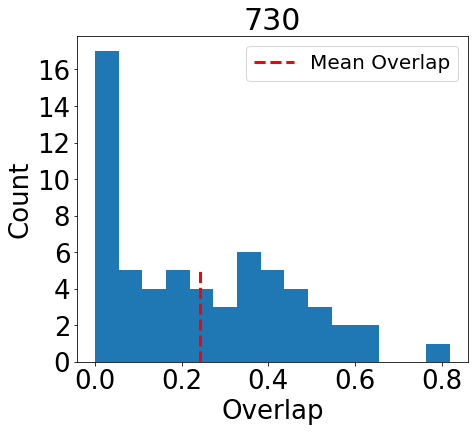

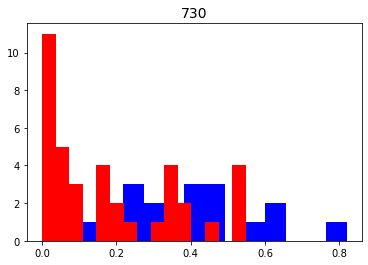

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252987 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102305 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

D1_nimbus_051221
[31.1, 9.7, 9.0, 2.1, 3.5, 0.9]
passed filtering
D2_nimbus_051221
len_dia_correlation
0.9999999999999997
╒═════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 30.4(8.9) 8.0(1.8) 3.8(1.0)   │
╞═════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len_dia_correlation │   0.20168 │ 46.8(7.1) 11.2(1.6) 4.3(0.8)              │
╘═════════════════════╧═══════════╧═══════════════════════════════════════════╛
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
D2_nimbus_051221
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
passed filtering
D4_Post_Clean
len_dia_correlation
1.0000000000000002
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 52.4(24.6) 17.0(9.7) 3.2(0.7)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │  0.112338 │ 46.6(7.1) 9.8(2.3) 5.0(0.8)                 │

Mbalaha_2019_Figure_3_LightBlue
[23.9, 3.9, 6.6, 1.1, 3.6, nan]
passed filtering
Mbalaha_2019_Figure_3_Pink
Rafael_del_Cano_2019_Figure 1 Red
Rafael_del_Cano_2019_Figure 1 Red
[63.0, 12.0, 18.0, 6.0, 2.4, 1.1]
passed filtering
Tong_2017_Figure_1b_Magenta
Tong_2017_Figure_1b_Wine
Tong_2017_Figure_S1_Blue
Tong_2017_Figure_S1_Blue
[32.0, 10.0, 11.0, 2.0, 3.0, 0.7]
passed filtering
Tong_2017_Figure_S1_Green
Tong_2017_Figure_S1_Green
[32.0, 10.0, 12.0, 2.0, 2.7, 0.7]
passed filtering
Tong_2017_Figure_S1_LightBlue
Tong_2017_Figure_S1_LightBlue
[38.0, 10.0, 11.0, 2.0, 3.5, 0.7]
passed filtering
Tong_2017_Figure_S1_Pink
Tong_2017_Figure_S1_Pink
[40.0, 9.0, 10.0, 2.0, 3.8, 0.7]
passed filtering
Wei_2021_Figure_3_Blue
Wei_2021_Figure_3_Blue
[112.6, 9.4, 36.8, 3.1, 3.1, 0.4]
passed filtering
Wei_2021_Figure_3_Green
Wei_2021_Figure_3_Green
[105.9, 9.0, 26.2, 2.1, 4.1, 0.5]
passed filtering
Wei_2021_Figure_4f_Blue
Wei_2021_Figure_4f_Blue
[102.9, 9.7, 35.2, 4.1, 3.0, 0.5]
passed filtering
Wei_2021_F

B3_Post_Clean
[33.00854891976261, 2.829756474838717, 7.343246992405368, 1.2052150544145375, 4.812648134163067, 0.8319939601579407]
B4_Pre_Clean_sonic_0720
[76.07998138296236, 3.984857558273696, 16.15811541099635, 2.3537681992688317, 4.803695011130623, 0.7145285111194194]
B8_Post_Clean
[36.51952312836001, 5.506290093557515, 7.558160590226737, 1.1193083026009225, 5.0087270721212045, 0.9798058894755555]
C2_nimbus_051221
[28.074577529602504, 4.342911882738532, 7.224997242976907, 1.3114476527550474, 4.3279780149226585, 0.9043980688256478]
C2_nimbus_062521_rnd_1
[41.33529435936715, 7.469994934049398, 9.535336460844341, 1.0944686518859743, 4.376197782949904, 0.8622281943281663]
C4_nimbus_052621
[40.624023978923105, 10.784598036127576, 9.826976154114337, 2.613367773856881, 4.310106261637379, 0.8618345136264044]
C4_Post_Clean
[94.17686157781931, 12.55302341632313, 21.7019464417629, 3.450975103654227, 4.437886895949523, 0.8711374105236379]
C7_Post_Clean
[36.88493259323451, 6.258514880352784, 7.7

mean overlap = 0.24869007816870387
std overlap = 0.20994094186756848
median overlap = 0.18993882139304752


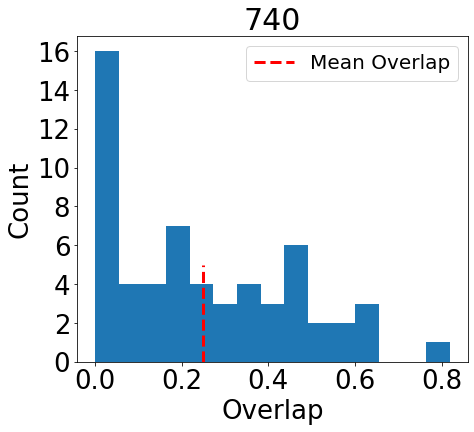

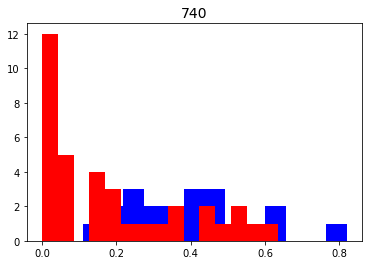

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252987 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102305 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

D2_nimbus_051221
len_dia_correlation
0.9999999999999997
╒═════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 30.4(8.9) 8.0(1.8) 3.8(1.0)   │
╞═════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len_dia_correlation │  0.250263 │ 45.1(6.8) 10.7(1.6) 4.3(0.8)              │
╘═════════════════════╧═══════════╧═══════════════════════════════════════════╛
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
D2_nimbus_051221
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
passed filtering
D4_Post_Clean
len_dia_correlation
1.0000000000000002
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 52.4(24.6) 17.0(9.7) 3.2(0.7)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │   0.09087 │ 44.0(6.5) 9.3(2.1) 5.0(0.8)                 │
╘═════════════════════╧═══════════╧══════════════════════════════

Wei_2021_Figure_4f_Pink
[71.7, 9.2, 20.9, 2.3, 3.5, 0.7]
passed filtering
Xingchen_Figure2_black
Xingchen_Figure2_black
[46.0, 3.0, 12.0, 1.0, 3.833333, nan]
passed filtering
Xingchen_Figure2_red
Xingchen_Figure3_black
Xingchen_Figure3_black
[44.0, 3.5, 10.0, 0.5, 4.4, nan]
passed filtering
Xingchen_Figure3_blue
Xingchen_Figure3_blue
[49.0, 4.0, 10.0, 1.0, 4.9, nan]
passed filtering
Xingchen_Figure3_red
Xingchen_Figure3_red
[52.5, 3.5, 12.0, 0.5, 4.375, nan]
passed filtering
Xingchen_Figure4_black
Xingchen_Figure4_black
[71.5, 4.5, 12.0, 1.0, 5.958333, nan]
passed filtering
Zhang_2014_Figure_4_Blue
Zhang_2014_Figure_4_Blue
[68.5, 5.5, 15.8, 1.5, 4.3, nan]
passed filtering
Zhang_2014_Figure_4_Red
Zhang_2014_Figure_4_Red
[91.1, 6.3, 24.3, 2.1, 3.7, nan]
passed filtering
Zhang_2014_Figure_4_Teal
Zhang_2014_Figure_4_Teal
[57.8, 4.6, 13.1, 1.0, 4.4, nan]
passed filtering
Zhang_2014_Figure_S2_Blue
Zhang_2014_Figure_S2_Blue
[62.3, 6.2, 11.1, 0.6, 5.6, nan]
passed filtering
Zhang_2014_Figure_S

mean overlap = 0.26296296630957455
std overlap = 0.21678455272087088
median overlap = 0.215045408803272


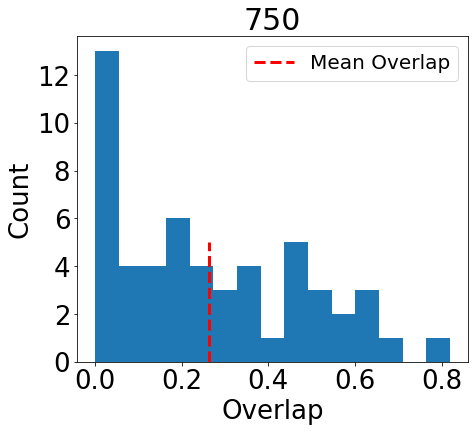

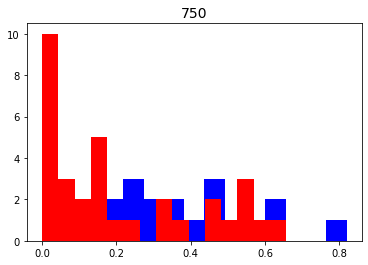

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252987 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102305 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

╒═════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 30.4(8.9) 8.0(1.8) 3.8(1.0)   │
╞═════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len_dia_correlation │   0.27226 │ 44.4(6.6) 10.5(1.5) 4.3(0.8)              │
╘═════════════════════╧═══════════╧═══════════════════════════════════════════╛
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
D2_nimbus_051221
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
passed filtering
D4_Post_Clean
len_dia_correlation
1.0000000000000002
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 52.4(24.6) 17.0(9.7) 3.2(0.7)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │ 0.0755775 │ 42.2(6.0) 8.9(2.0) 5.0(0.8)                 │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[52.4, 24.6, 17.0, 9.7, 3.2, 0.7]
D4_Po

Xingchen_Figure3_blue
[49.0, 4.0, 10.0, 1.0, 4.9, nan]
passed filtering
Xingchen_Figure3_red
Xingchen_Figure3_red
[52.5, 3.5, 12.0, 0.5, 4.375, nan]
passed filtering
Xingchen_Figure4_black
Xingchen_Figure4_black
[71.5, 4.5, 12.0, 1.0, 5.958333, nan]
passed filtering
Zhang_2014_Figure_4_Blue
Zhang_2014_Figure_4_Blue
[68.5, 5.5, 15.8, 1.5, 4.3, nan]
passed filtering
Zhang_2014_Figure_4_Red
Zhang_2014_Figure_4_Red
[91.1, 6.3, 24.3, 2.1, 3.7, nan]
passed filtering
Zhang_2014_Figure_4_Teal
Zhang_2014_Figure_4_Teal
[57.8, 4.6, 13.1, 1.0, 4.4, nan]
passed filtering
Zhang_2014_Figure_S2_Blue
Zhang_2014_Figure_S2_Blue
[62.3, 6.2, 11.1, 0.6, 5.6, nan]
passed filtering
Zhang_2014_Figure_S2_Red
Zhang_2014_Figure_S2_Red
[46.6, 4.6, 13.2, 0.8, 3.5, nan]
passed filtering
Zhang_2021_Figure_S1b_Red
Zhang_2021_Figure_S2_Blue
Zhang_2021_Figure_S2_Green
Zhang_2021_Figure_S2_Yellow
Zhang_2021_Figure_S3_Cyan
Zhang_2021_Figure_S5_Black
Zhang_2021_Figure_S5_Cyan
Zhang_2021_Figure_S5_Green
Zhang_2021_Figure_S5

C7_Post_Clean
[36.88493259323451, 6.258514880352784, 7.786666689643306, 1.2822527990115697, 4.946939122743844, 1.0872384993060942]
Chang_2018_Figure_2_Red
[34.998498393253584, 4.875991430008604, 9.661761993545415, 1.224956647483995, 3.6706414146237125, 0.636419992556244]
D12_Post_Clean_sonic_071621
[34.076506781685254, 4.651152579974423, 7.346641680527633, 0.991668732688004, 4.785924919542374, 0.8466077859920282]
D1_nimbus_051221
[65.16934113398577, 12.144272944055892, 16.22524103131508, 2.720152858524515, 4.112824448550842, 0.9679347440528562]
D2_nimbus_051221
[44.44965434417932, 6.579735766402137, 10.548444690512376, 1.549128548128007, 4.292476769411305, 0.8341228997018442]
D4_Post_Clean
[42.215309194428094, 6.035405121410194, 8.915129207524373, 2.018343597668271, 4.988907950007053, 0.7951057728952402]
Dopamine Bottom Fig panel 3 corrected
[103.28152717409426, 13.055688387175277, 18.415631011884088, 3.01188894885993, 5.6886393658697, 0.7599030970884936]
F12_Post_Clean_sonic_071621
[3

mean overlap = 0.2590785667595889
std overlap = 0.21110727082671912
median overlap = 0.2480884454969661


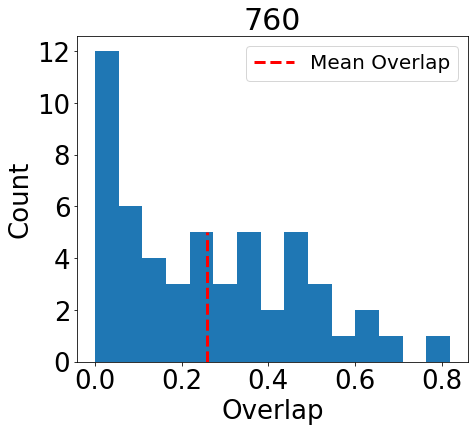

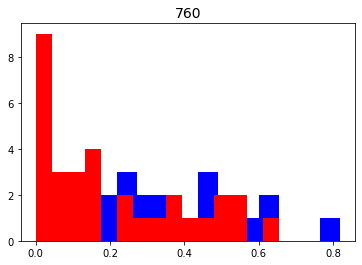

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252987 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102305 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

D2_nimbus_051221
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
passed filtering
D4_Post_Clean
len_dia_correlation
1.0000000000000002
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 52.4(24.6) 17.0(9.7) 3.2(0.7)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │ 0.0612323 │ 40.7(5.5) 8.6(1.9) 5.0(0.8)                 │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[52.4, 24.6, 17.0, 9.7, 3.2, 0.7]
D4_Post_Clean
[52.4, 24.6, 17.0, 9.7, 3.2, 0.7]
passed filtering
Dopamine Bottom Fig panel 3 corrected
Dopamine Bottom Fig panel 3 corrected
[97.1, 16.0, 20.2, 4.62, 4.9, 0.9]
passed filtering
F12_Post_Clean_sonic_071621
len_dia_correlation_rel_std
0.9999999999999999
╒═════════════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 36.9(9.1) 8.6(2.0) 4.3(0.

Zhang_2021_Figure_S2_Yellow
Zhang_2021_Figure_S3_Cyan
Zhang_2021_Figure_S5_Green
Zhang_2021_Figure_S5_Red
Zhang_2021_Figure_S5_Yellow
Zhang_2021_Figure_S6b_Yellow
Zhang_2021_Figure_S6c_Olive
52
A11_Post_Clean
[37.48730451256067, 5.443035373787867, 7.541878412391414, 1.0795720761916123, 5.133095369288563, 0.9676087782144934]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A12_Post_Clean
[44.21794939366498, 6.714017978817783, 7.759566744588762, 1.1610179842275254, 5.864538660679826, 1.0773404296995737]
A12_Post_Clean
[44.6, 13.8, 12.0, 3.9, 3.8, 1.3]
A7_Post_Clean
[39.33177650110443, 6.7351457033462445, 8.087464865471912, 1.3520252651421836, 5.049333475690844, 1.1248736715845475]
A7_Post_Clean
[36.8, 12.0, 11.9, 3.8, 3.2, 1.1]
B2_Post_Clean
[30.569214712258848, 2.0679493124370074, 7.515285358131899, 1.373972012195521, 4.41933174442079, 0.8150001053937983]
B2_Post_Clean
[40.2, 12.2, 11.1, 3.6, 3.7, 1.0]
B3_Post_Clean
[33.38088138530244, 2.625289057886829, 7.388100263120372, 1.22252979900

mean overlap = 0.2795798553347204
std overlap = 0.21437651289678397
median overlap = 0.2662255803395093


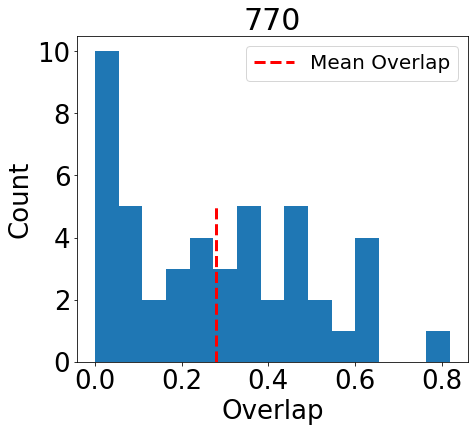

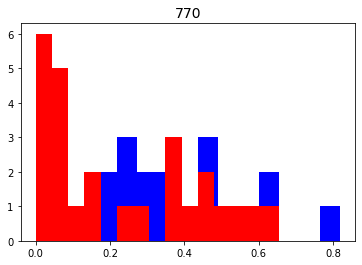

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252987 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102305 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

╒═════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 30.4(8.9) 8.0(1.8) 3.8(1.0)   │
╞═════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len_dia_correlation │  0.267199 │ 44.6(6.6) 10.6(1.6) 4.3(0.8)              │
╘═════════════════════╧═══════════╧═══════════════════════════════════════════╛
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
D2_nimbus_051221
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
passed filtering
D4_Post_Clean
len_dia_correlation
1.0000000000000002
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 52.4(24.6) 17.0(9.7) 3.2(0.7)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │ 0.0484003 │ 39.1(4.8) 8.3(1.8) 5.0(0.8)                 │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[52.4, 24.6, 17.0, 9.7, 3.2, 0.7]
D4_Po

Zhang_2021_Figure_S2_Blue
Zhang_2021_Figure_S2_Green
Zhang_2021_Figure_S2_Yellow
Zhang_2021_Figure_S5_Red
Zhang_2021_Figure_S5_Yellow
Zhang_2021_Figure_S6c_Olive
50
A11_Post_Clean
[37.48730451256067, 5.443035373787867, 7.541878412391414, 1.0795720761916123, 5.133095369288563, 0.9676087782144934]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A12_Post_Clean
[44.21794939366498, 6.714017978817783, 7.759566744588762, 1.1610179842275254, 5.864538660679826, 1.0773404296995737]
A12_Post_Clean
[44.6, 13.8, 12.0, 3.9, 3.8, 1.3]
A7_Post_Clean
[39.33177650110443, 6.7351457033462445, 8.087464865471912, 1.3520252651421836, 5.049333475690844, 1.1248736715845475]
A7_Post_Clean
[36.8, 12.0, 11.9, 3.8, 3.2, 1.1]
B2_Post_Clean
[30.630930995053617, 2.073005536348138, 7.513651755930923, 1.3657211598880068, 4.42288513282914, 0.8126352741751807]
B2_Post_Clean
[40.2, 12.2, 11.1, 3.6, 3.7, 1.0]
B3_Post_Clean
[33.3173940110254, 2.656045982392395, 7.380804493167876, 1.2203550407670458, 4.828663066717759, 0.83

mean overlap = 0.2829382846011206
std overlap = 0.20984288586355754
median overlap = 0.27254423827747726


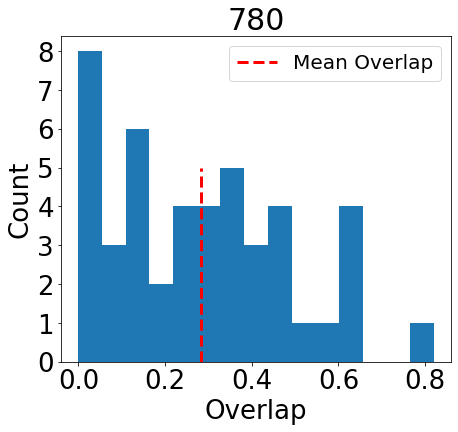

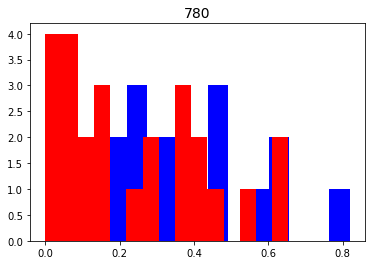

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252987 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102305 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

len_dia_correlation_rel_std
0.9999999999999999
╒═════════════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 36.9(9.1) 8.6(2.0) 4.3(0.9)   │
╞═════════════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.453404 │ 32.7(3.9) 7.2(0.9) 4.6(0.7)               │
╘═════════════════════════════╧═══════════╧═══════════════════════════════════════════╛
[36.9, 9.1, 8.6, 2.0, 4.3, 0.9]
F12_Post_Clean_sonic_071621
[36.9, 9.1, 8.6, 2.0, 4.3, 0.9]
passed filtering
G3_nimbus_052621
len_dia_correlation
0.9999999999999997
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 39.8(14.3) 10.1(2.6) 3.9(1.1)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │  0.159145 │ 32.9(3.0) 7.1(1.2) 5.1(0.8)                 │
╘═══════════════════

mean overlap = 0.3022821951603981
std overlap = 0.20458640825422972
median overlap = 0.2924448589433356


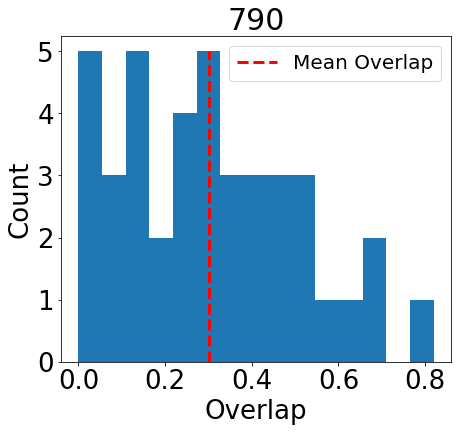

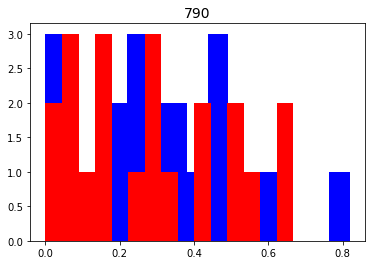

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252987 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102305 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

D2_nimbus_051221
len_dia_correlation
0.9999999999999997
╒═════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 30.4(8.9) 8.0(1.8) 3.8(1.0)   │
╞═════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len_dia_correlation │  0.240505 │ 45.4(7.0) 10.9(1.6) 4.3(0.8)              │
╘═════════════════════╧═══════════╧═══════════════════════════════════════════╛
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
D2_nimbus_051221
[30.4, 8.9, 8.0, 1.8, 3.8, 1.0]
passed filtering
D4_Post_Clean
len_dia_correlation
1.0000000000000002
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 52.4(24.6) 17.0(9.7) 3.2(0.7)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │ 0.0840062 │ 51.8(3.2) 10.8(2.1) 5.0(0.8)                │
╘═════════════════════╧═══════════╧══════════════════════════════

mean overlap = 0.2992987201190151
std overlap = 0.20818395209779175
median overlap = 0.2798402362322497


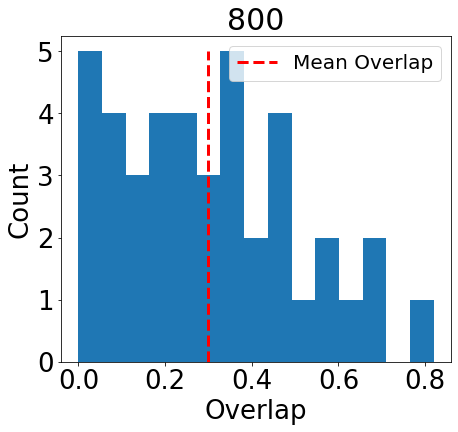

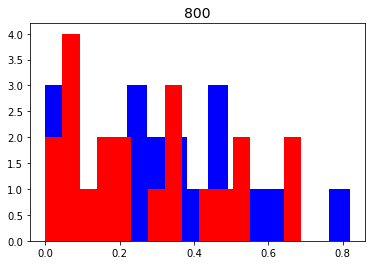

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252988 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102304 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

D4_Post_Clean
len_dia_correlation
1.0000000000000002
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 52.4(24.6) 17.0(9.7) 3.2(0.7)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │ 0.0906376 │ 52.6(3.5) 10.9(2.1) 5.0(0.8)                │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[52.4, 24.6, 17.0, 9.7, 3.2, 0.7]
D4_Post_Clean
[52.4, 24.6, 17.0, 9.7, 3.2, 0.7]
passed filtering
Dopamine Bottom Fig panel 3 corrected
Dopamine Bottom Fig panel 3 corrected
[97.1, 16.0, 20.2, 4.62, 4.9, 0.9]
passed filtering
F12_Post_Clean_sonic_071621
len_dia_correlation_rel_std
0.9999999999999999
╒═════════════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 36.9(9.1) 8.6(2.0) 4.3(0.9)   │
╞═════════════════════════════╪═══════════╪════════════════

mean overlap = 0.304997807086619
std overlap = 0.21860619254770683
median overlap = 0.27950862508849067


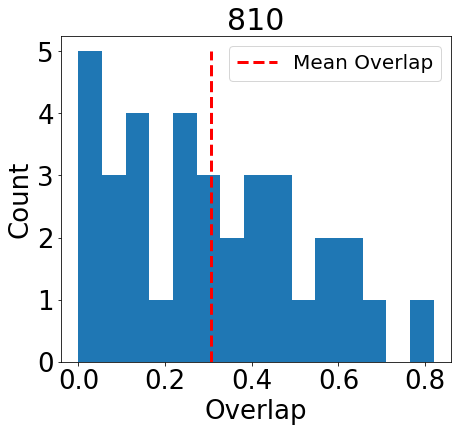

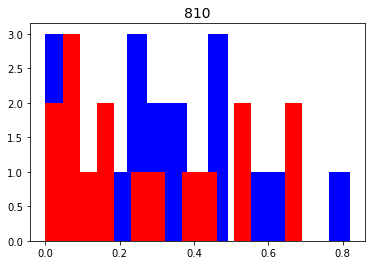

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252988 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102304 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 52.4(24.6) 17.0(9.7) 3.2(0.7)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │ 0.0957811 │ 53.4(3.9) 11.1(2.2) 5.0(0.8)                │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[52.4, 24.6, 17.0, 9.7, 3.2, 0.7]
D4_Post_Clean
[52.4, 24.6, 17.0, 9.7, 3.2, 0.7]
passed filtering
Dopamine Bottom Fig panel 3 corrected
Dopamine Bottom Fig panel 3 corrected
[97.1, 16.0, 20.2, 4.62, 4.9, 0.9]
passed filtering
F12_Post_Clean_sonic_071621
len_dia_correlation_rel_std
0.9999999999999999
╒═════════════════════════════╤═══════════╤═══════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 36.9(9.1) 8.6(2.0) 4.3(0.9)   │
╞═════════════════════════════╪═══════════╪═══════════════════════════════════════════╡
│ len_dia_correlation_re

mean overlap = 0.3245950849087526
std overlap = 0.2036845417875587
median overlap = 0.30234289654095425


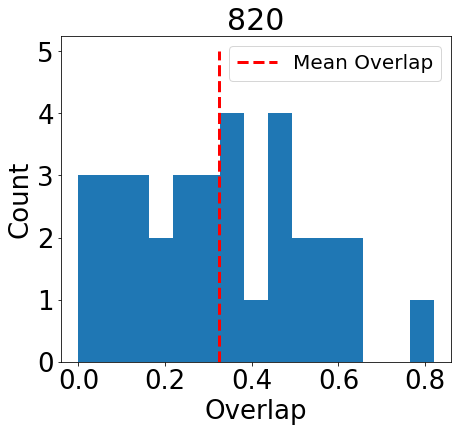

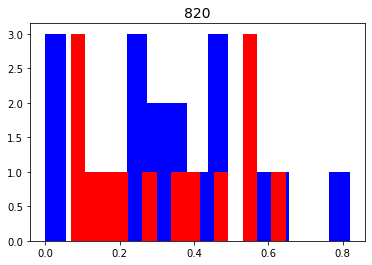

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252988 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102304 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

0.9999999999999997
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 39.8(14.3) 10.1(2.6) 3.9(1.1)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │  0.151901 │ 34.0(2.7) 7.2(1.3) 5.2(0.8)                 │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[39.8, 14.3, 10.1, 2.6, 3.9, 1.1]
G3_nimbus_052621
[39.8, 14.3, 10.1, 2.6, 3.9, 1.1]
passed filtering
G4_Post_Clean
len_dia_correlation
1.0000000000000004
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │   Overlap │ Predictions 61.7(19.5) 17.8(5.5) 3.5(0.9)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │ 0.0565649 │ 54.2(2.2) 10.9(1.8) 5.1(0.9)                │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[61.7,

mean overlap = 0.3238924641858933
std overlap = 0.20912971452641327
median overlap = 0.2996185012202647


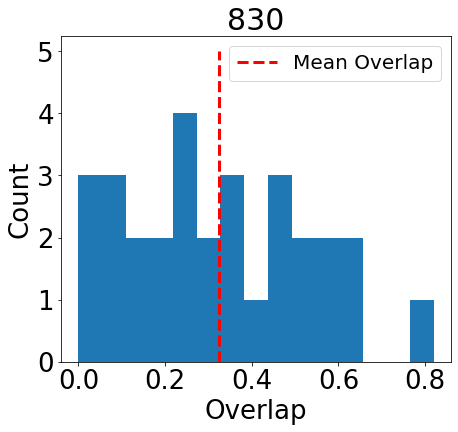

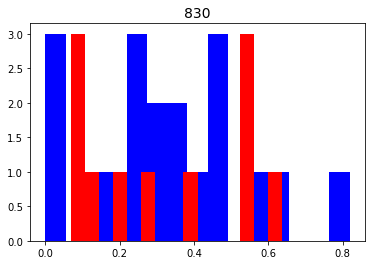

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252988 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102304 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

Gallagher_2020_Figure_S11a_Black
Gallagher_2020_Figure_S11a_Blue
Gallagher_2020_Figure_S11a_Green
Gallagher_2020_Figure_S11a_Pink
Gallagher_2020_Figure_S11b_Blue
Gallagher_2020_Figure_S2a_Blue
Gallagher_2020_Figure_S2b_Green
H1_Post_Clean
len_dia_correlation
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │ Overlap   │ Predictions 36.5(14.6) 10.5(3.7) 3.5(1.1)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │ NA        │ Failed Fit, all fits hit bounds             │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[36.5, 14.6, 10.5, 3.7, 3.5, 1.1]
H1_Post_Clean
[36.5, 14.6, 10.5, 3.7, 3.5, 1.1]
passed filtering
Katherinne_Requejo_2017_FigureS6A_Green
Katherinne_Requejo_2017_FigureS6A_Green
[36.72, 4.37, 6.86, 0.45, 5.36, 0.57]
passed filtering
Katherinne_Requejo_2017_FigureS6A_Red_same_spectrum_as_Katherinne_Requejo_2017_Figure_1A_Orange_3

mean overlap = 0.29291529188036336
std overlap = 0.21510109555044735
median overlap = 0.26623611773586137


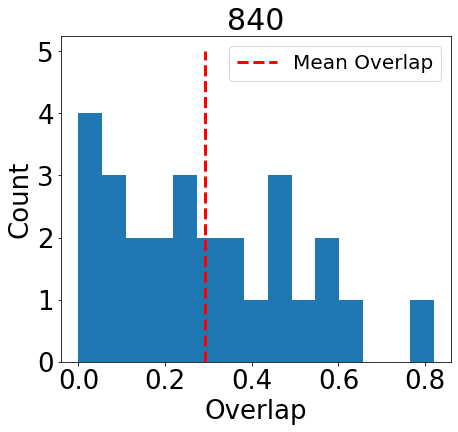

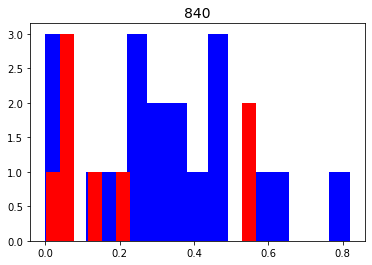

A11_Post_Clean
len_dia_correlation_rel_std
1.0000000000000004
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 37.5(12.2) 10.2(2.8) 3.8(1.2)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.252988 │ 37.5(5.4) 7.5(1.1) 5.1(1.0)                 │
╘═════════════════════════════╧═══════════╧═════════════════════════════════════════════╛
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
A11_Post_Clean
[37.5, 12.2, 10.2, 2.8, 3.8, 1.2]
passed filtering
A12_Post_Clean
len_dia_correlation_rel_std
1.0
╒═════════════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type                  │   Overlap │ Predictions 44.6(13.8) 12.0(3.9) 3.8(1.3)   │
╞═════════════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation_rel_std │  0.102304 │ 44.2(6.7) 7.8(1.2) 5.9(1.1)

Gallagher_2020_Figure_S11a_Pink
Gallagher_2020_Figure_S11b_Blue
Gallagher_2020_Figure_S2a_Blue
Gallagher_2020_Figure_S2b_Green
H1_Post_Clean
len_dia_correlation
╒═════════════════════╤═══════════╤═════════════════════════════════════════════╕
│ Model Type          │ Overlap   │ Predictions 36.5(14.6) 10.5(3.7) 3.5(1.1)   │
╞═════════════════════╪═══════════╪═════════════════════════════════════════════╡
│ len_dia_correlation │ NA        │ Failed Fit, all fits hit bounds             │
╘═════════════════════╧═══════════╧═════════════════════════════════════════════╛
[36.5, 14.6, 10.5, 3.7, 3.5, 1.1]
H1_Post_Clean
[36.5, 14.6, 10.5, 3.7, 3.5, 1.1]
passed filtering
Katherinne_Requejo_2017_FigureS6A_Green
Katherinne_Requejo_2017_FigureS6A_Green
[36.72, 4.37, 6.86, 0.45, 5.36, 0.57]
passed filtering
Katherinne_Requejo_2017_FigureS6A_Red_same_spectrum_as_Katherinne_Requejo_2017_Figure_1A_Orange_3
Katherinne_Requejo_2017_FigureS6A_Red_same_spectrum_as_Katherinne_Requejo_2017_Figure_1A_Orange_3

Xingchen_Figure4_black
[73.78889492883788, 12.592514749159138, 13.192642851306402, 3.422271319496933, 5.801801836321296, 1.0410752314862584]
Zhang_2014_Figure_4_Teal
[34.032582428497705, 3.857982376536804, 7.374371981763711, 0.8337784037636058, 4.685733950062002, 0.6870418203524308]
Zhang_2014_Figure_S2_Blue
[43.0579787160965, 7.16365904027434, 7.861511840519643, 1.282590805880868, 5.645709130666745, 0.9337900641856476]
28
[37.5, 44.6, 36.8, 48.3, 54.7, 37.1, 67.1, 35.7, 39.9, 52.4, 97.1, 36.9, 39.8, 61.7, 36.72, 45.41, 45.41, 37.38, 34.35, 87.24, 115.8, 105.9, 60.4, 49.0, 71.5, 57.8, 62.3]
mean overlap = 0.3030203575092128
std overlap = 0.23308398263025965
median overlap = 0.26623611773586137


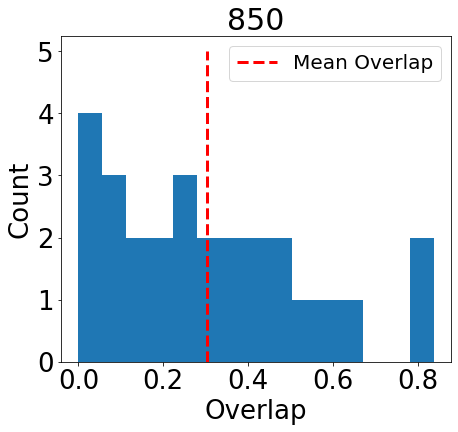

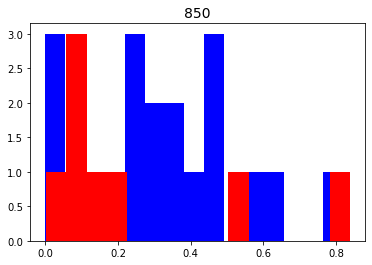

In [65]:
for cutoff in cutoffs:
    output_files = glob.glob('C:/Users/smgls/PycharmProjects/Data_Models_and_Spectra/Predictions/'+ str(cutoff) + ' nm on processed/'+ str(cutoff) + ' nm on with true vals/*.joblib')

    output_files_for_analysis = []
    for file in output_files:
        output_file = joblib.load(file)
        if type(output_file) != list: 
            print(output_file.name)
            if 'Clean' in file or 'Rod' in file or 'nimbus' in file:
                temp = output_file.tabulate_results()[0][2]
                true_values = []
                temp_val = ''
                for char in temp[11:len(temp)]:
                    if char not in '()':
                        temp_val += char
                    if char in '()':
                        true_values.append(float(temp_val))
                        temp_val = ''
                output_file.true_values = true_values
                print(output_file.true_values)
            if output_file.smoothed_spectrum[len(output_file.smoothed_spectrum)-1] < 0.5:
                if 'Zhang_2021' not in file: 
                    smoothed_spectrum = savgol_filter(output_file.inputted_spectrum, output_file.smoothing_parameters[0], output_file.smoothing_parameters[1])
                    inten_max = max(smoothed_spectrum)
                    peak_loc = list(smoothed_spectrum).index(inten_max)
                    wavelength_loc = output_file.wavelengths[peak_loc]
                    if wavelength_loc > cutoff+5:
                        try: 
                            if float(output_file.true_values[2]) > 6: 
                                print(output_file.name)
                                print(output_file.true_values)
                                print('passed filtering')
                                output_files_for_analysis.append(output_file)
                        except TypeError:
                            pass
    test_spectra_obj = test_spectra_fit(str(cutoff) + ' nm on', 'Blue edge cutoff value in fit summary, location' + 
                                        'still 650 for spectra where red edge doesnt go to the baseline', output_files_for_analysis)
    joblib.dump(test_spectra_obj, str(cutoff+5) + '_nm_on.joblib')
    summary_stats.append(test_spectra_obj.visualize_overlaps(str(cutoff)))

700
mean overlap = 0.18239468635561018
std overlap = 0.20870069948705036
median overlap = 0.06617624793583873


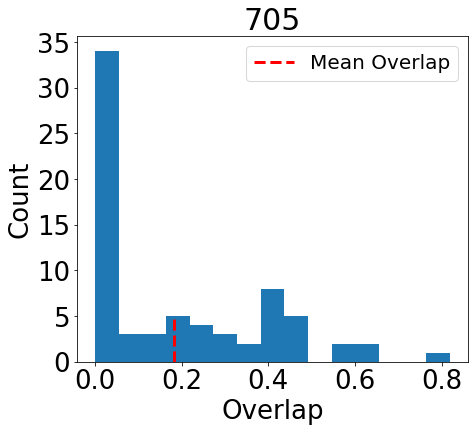

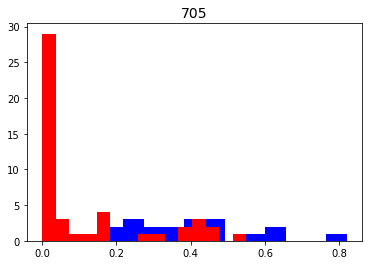

710
mean overlap = 0.20048126219014814
std overlap = 0.21063643911936533
median overlap = 0.14062714066601226


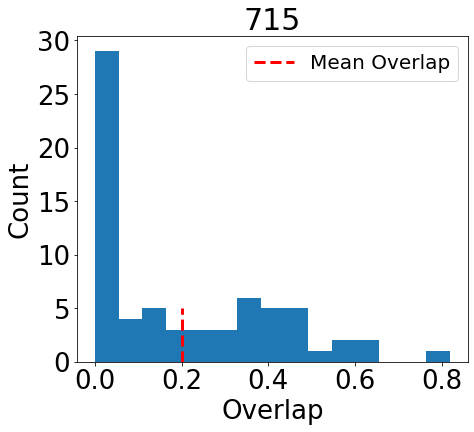

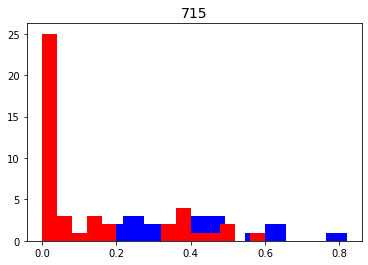

720
mean overlap = 0.23118628108877132
std overlap = 0.20488803882438225
median overlap = 0.18927732694660354


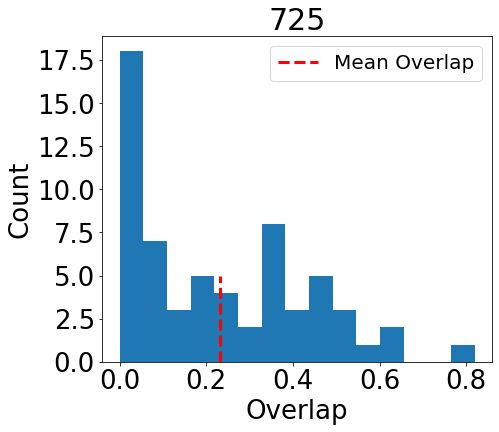

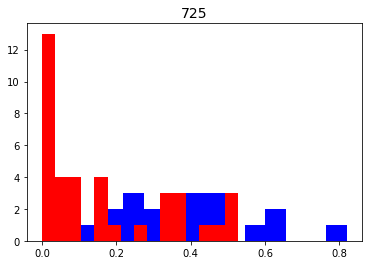

730
mean overlap = 0.24327387675377868
std overlap = 0.20545604984791122
median overlap = 0.20642718342239852


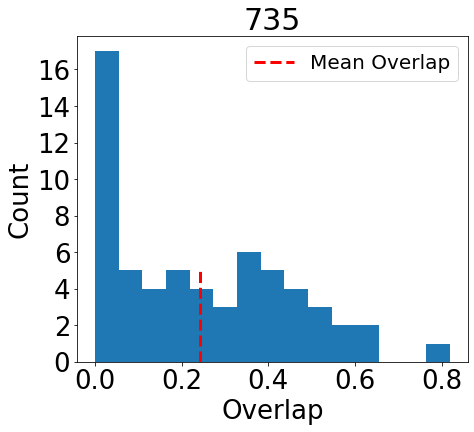

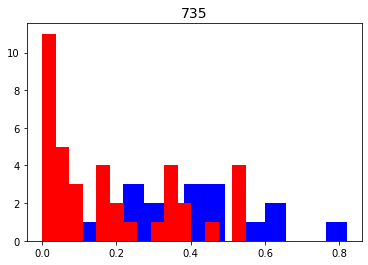

740
mean overlap = 0.24869007816870387
std overlap = 0.20994094186756848
median overlap = 0.18993882139304752


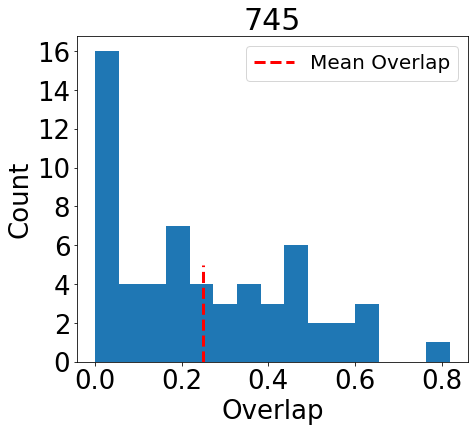

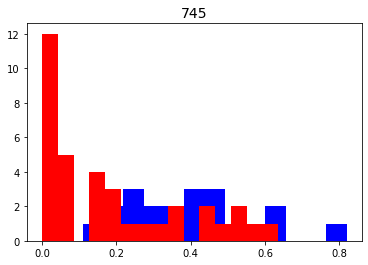

750
mean overlap = 0.26296296630957455
std overlap = 0.21678455272087088
median overlap = 0.215045408803272


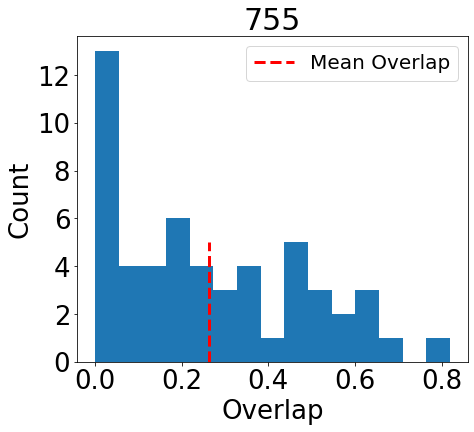

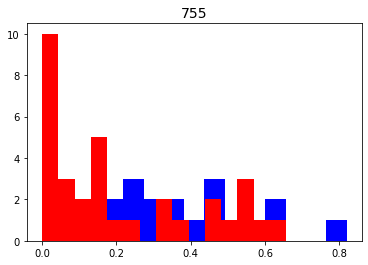

760
mean overlap = 0.2590785667595889
std overlap = 0.21110727082671912
median overlap = 0.2480884454969661


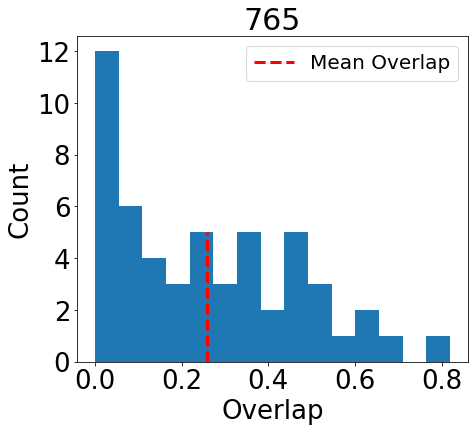

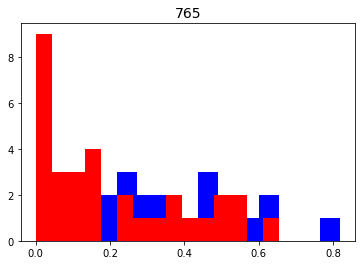

770
mean overlap = 0.2795798553347204
std overlap = 0.21437651289678397
median overlap = 0.2662255803395093


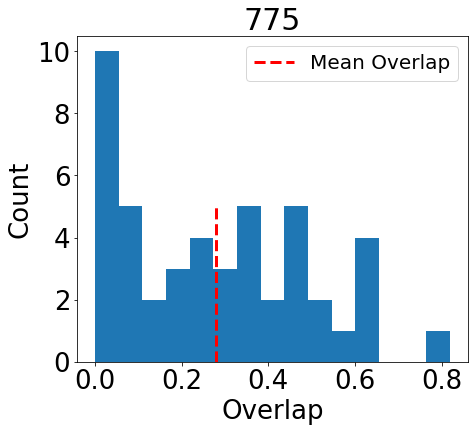

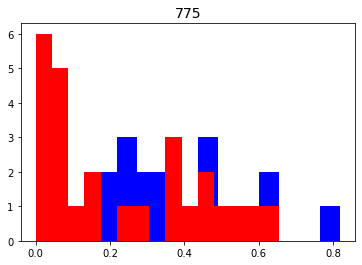

780
mean overlap = 0.2829382846011206
std overlap = 0.20984288586355754
median overlap = 0.27254423827747726


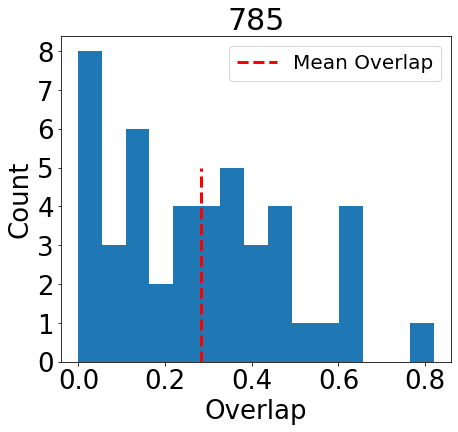

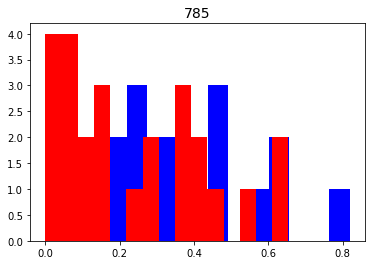

790
mean overlap = 0.3022821951603981
std overlap = 0.20458640825422972
median overlap = 0.2924448589433356


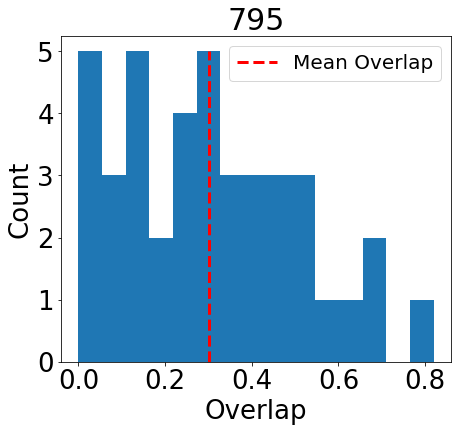

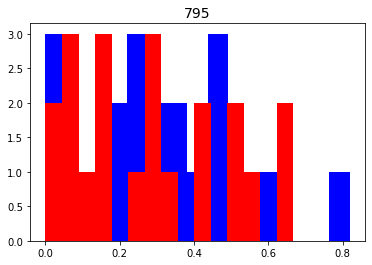

800
mean overlap = 0.2992987201190151
std overlap = 0.20818395209779175
median overlap = 0.2798402362322497


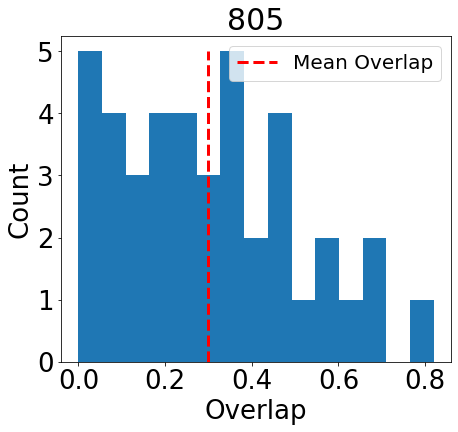

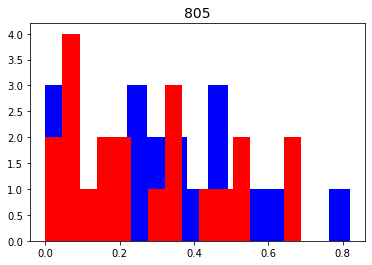

810
mean overlap = 0.304997807086619
std overlap = 0.21860619254770683
median overlap = 0.27950862508849067


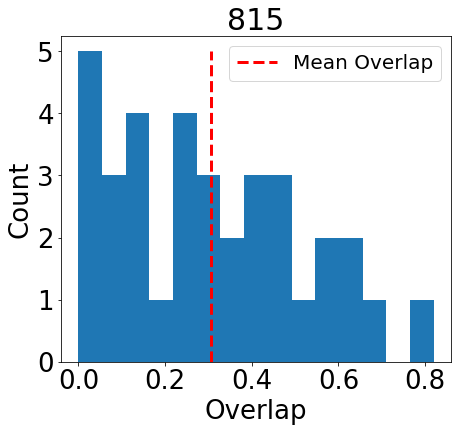

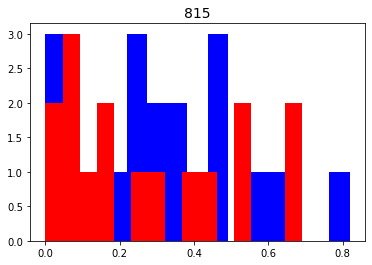

820
mean overlap = 0.3245950849087526
std overlap = 0.2036845417875587
median overlap = 0.30234289654095425


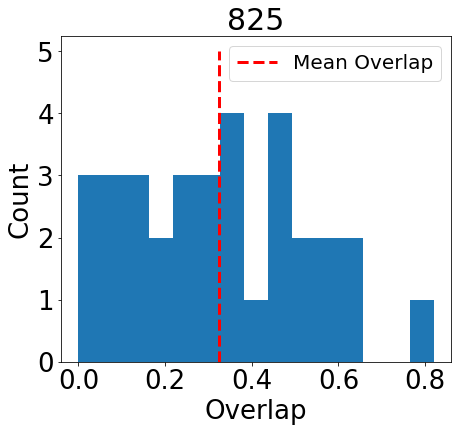

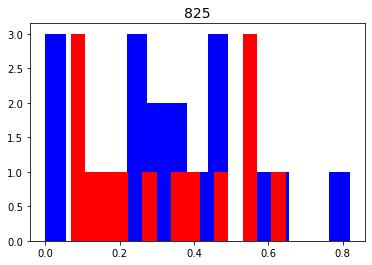

830
mean overlap = 0.3238924641858933
std overlap = 0.20912971452641327
median overlap = 0.2996185012202647


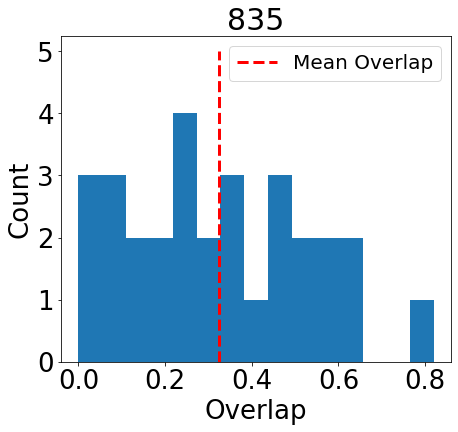

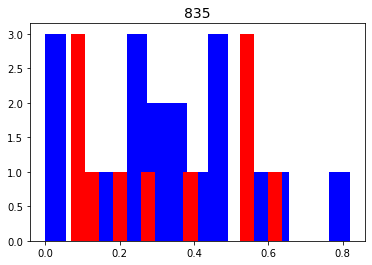

840
mean overlap = 0.29291529188036336
std overlap = 0.21510109555044735
median overlap = 0.26623611773586137


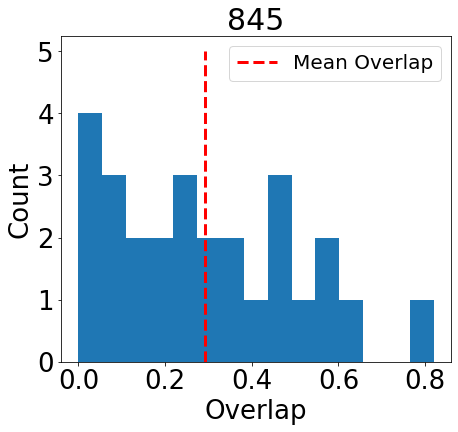

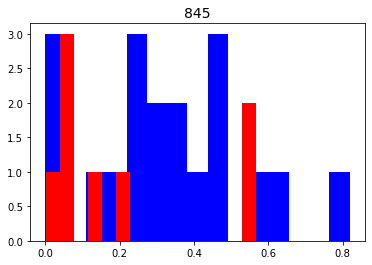

850
mean overlap = 0.3030203575092128
std overlap = 0.23308398263025965
median overlap = 0.26623611773586137


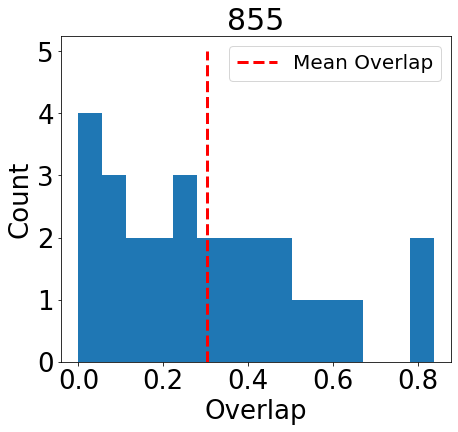

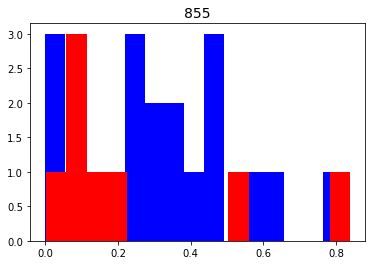

In [68]:
cutoffs = np.arange(700, 860, 10)
summary_stats = []
for cutoff in cutoffs: 
    print(cutoff)
    test_spectra_obj = joblib.load(str(cutoff+5) + '_nm_on.joblib')
    temp = test_spectra_obj.visualize_overlaps(str(cutoff+5))
    summary_stats.append(temp)
    
# how does the fit do on the added spectra specifically? 
# compare on spectra fitted by 800 to all other cutoffs 
# compare number of fitted spectra to quality of fit 
# run fit out to 850 

In [69]:
variable_overlap_means = []
variable_overlap_num_fit = []
for i in range(0, len(cutoffs)):
    variable_overlap_means.append(np.mean(np.asarray(summary_stats).T[7][i]))
    variable_overlap_num_fit.append(len(np.asarray(summary_stats).T[7][i]))

C:\Users\smgls\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
C:\Users\smgls\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [70]:
cutoffs

array([700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820,
       830, 840, 850])

In [71]:
variable_overlap_num_fit

[48, 45, 38, 38, 36, 33, 32, 26, 25, 21, 21, 16, 14, 11, 8, 8]

In [72]:
variable_overlap_means

[0.1077859136413285,
 0.13054474507333463,
 0.1677593648600963,
 0.18261717038927155,
 0.1881239056879263,
 0.21686232203474837,
 0.2089881401464963,
 0.23448883258313585,
 0.2388647015232487,
 0.2844632108776157,
 0.27863833103491537,
 0.2778216429309218,
 0.3201329172037087,
 0.3169997240399897,
 0.20986698995411204,
 0.24397158645147898]

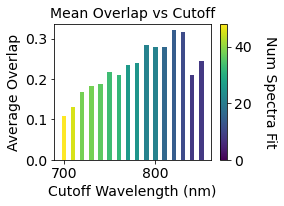

In [73]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))
variable_overlap_num_fit_color_normalized = [x / max(variable_overlap_num_fit) for x in variable_overlap_num_fit]
my_cmap = plt.get_cmap("viridis")
colors = my_cmap(variable_overlap_num_fit_color_normalized)
sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(variable_overlap_num_fit)))

sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Num Spectra Fit', fontsize = 14, rotation=270,labelpad=25)
cbar.ax.tick_params(labelsize=14)

ax.set_title('Mean Overlap vs Cutoff', fontsize = 14)
ax.bar(cutoffs, variable_overlap_means, width = 5, color = colors)
ax.set_ylabel('Average Overlap', fontsize = 14, color = 'k')
ax.tick_params(axis='y', labelcolor='k', labelsize= 14)
ax.set_xlabel('Cutoff Wavelength (nm)', fontsize = 14)
ax.tick_params(axis='x', labelcolor='k', labelsize= 14)
ax.set_yticks([0.0, 0.1, 0.2, 0.3])
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.savefig('Fig_3_overlap_vs_cutoff.pdf', bbox_inches = 'tight', transparent = True)
plt.show()